In [1]:
import json
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import os
from math import log
import requests
from bs4 import BeautifulSoup
#import pillow
from wordcloud import WordCloud
from PIL import Image
import gc
import pprint
pd.set_option('display.max_columns',500)

In [57]:
gc.collect()

264

# 0. Functions

In [278]:
def vocab_score(df):
    '''
    this function takes a dataframe as input, then iterates on all the rows of the dataframe
    it then returns the number of unique words, the total number of words, and the ratio of these
    for each row, in a dataframe
    '''
    vocabscores = []
    for i in range(df.shape[0]):
        item = {}
        item['name'] = df.index[i]
        item['unique_words'] = np.count_nonzero(df.iloc[i,:])
        item['total_words'] = df.iloc[i,:].sum()
        item['vocabindex'] = item['unique_words'] / item['total_words']
        vocabscores.append(item)
    return pd.DataFrame(vocabscores)

def get_soup(url):
    '''
    Tries to get the html code of a web page, returns Failure if it is unsuccessful.
    '''
    # choosing a random header from the previously given list
    #header = {'User-Agent' : random.choice(user_agent_list)} 
    #header = {'User-Agent':"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/534.30 (KHTML, like Gecko) Chrome/12.0.742.112 Safari/534.30"}

    # delaying the request for a random number of seconds from the range given in delays
    #delay = random.choice(delays)
    #time.sleep(delay)
    
    try:
        r = requests.get(url, 
                         #headers = header,
                         timeout = 15)
        if r.status_code == 200:
            soup = BeautifulSoup(r.content,'html.parser')
            siker = True
        else:
            print('Bad status code! STOPPED')
            siker=False
            soup = ''
    except:
        soup=""
        siker=False
    
    # If it could reach the page, but got an error message, the function returns failure
    try:
        soup.find("div", {"class":"error_code"}).text==404
        siker=False
    
    except:
        pass
    
    # The function returns a boolean (success), and the html text of the webpage
    return siker,soup

# 1. Reading in the data

In [2]:
df = pd.read_csv('DTM_with_meta_FINAL.csv', sep = ';')
df.head(3)

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,URL,ARTIST,ARTISTSCORE,ALBUM,TITLE,YEAR,LYRICS,CLEANLYRICS,ind,00n9na,100k,100s,10k,10s,10th,11s,11th,12play,12s,12th,13th,14th,15s,15th,16s,16th,17th,18th,1k,1s,1st,200k,20k,20s,21st,22nd,22s,23s,24hrs,24k,24s,25th,26s,27th,28s,28th,2am,2door,2g,2k,2nd,2pac,2pacalypse,2s,2way,30k,30s,31st,36s,3am,3d,3k,3oh5,3rd,3s,40k,40s,44s,45s,45th,49ers,4am,4door,4g,4hunnid,4k,4ktrey,4l,4play,4s,4th,500k,50k,50s,5am,5s,5star,5th,60k,60s,62s,6ix,6ix9ine,6s,6th,70s,7s,7th,808s,80k,80s,8ball,8th,90s,9s,9th,a1,aa,aaa,aaaa,aaaaaaa,aaaah,aaaahhhhhhhh,aaah,aaahhh,aaahhhh,aaall,aaand,aah,aahhh,aaliyah,aaron,aay,aayi,ab,abajo,abandon,abandoned,abc,abdomen,abe,abel,abide,ability,ablaze,able,abnormal,aboard,abomination,abort,aborted,abortion,abortions,aboutcha,abracadabra,abraham,abroad,abs,absence,absent,absolut,absolute,absolutely,absorb,abstract,absurd,abu,abundance,abuse,abused,abuser,abusers,abusin,abusing,abusive,abyss,ac,acabo,academy,acapella,accelarate,accelerate,accent,accents,accept,acceptance,accepted,acceptin,accepting,access,accessory,accident,accidentally,accolades,accompanied,accomplice,accomplish,accomplished,accomplishments,accord,according,accordingly,account,accountable,accountant,accountants,accounts,accuracy,accurate,accusations,accuse,accused,accusing,accussing,accustomed,ace,acercame,aces,ache,aches,achieve,achieved,achievement,achievements,achiever,achieving,achilles,achin,aching,achoo,acid,acknowledge,acknowledged,ackrite,acne,acquainted,acquire,acquired,acquitted,acre,acres,acrobat,acrobatic,acrobatics,acronym,across,act,actavis,acted,actin,acting,action,actions,activate,activated,activator,active,activis,activist,...,yayo,ye,yea,yeaa,yeaaa,yeaaaa,yeaaaaah,yeaaaah,yeaaah,yeaah,yeaahh,yeaahhh,yeah,yeaheaheah,yeahh,yeahhea,yeahhh,yeahhhh,yeahhhhh,yeahhhhhhh,yeahyeah,yeahyeahyeah,yeahyeahyeahyeahyeahyeahyeahyeahyeah,yean,year,yearly,yearn,yearnin,yearning,years,yeast,yeayeah,yee,yeeaaaahhhh,yeeaah,yeeaahh,yeeah,yeeahh,yeeeaaahhh,yeeeah,yeeeeah,yeeeeeah,yeeeeeeeeah,yeehaw,yeehee,yeen,yeezus,yeezy,yeezys,yeh,yelawolf,yell,yella,yelled,yellin,yelling,yellow,yells,yen,yep,yer,yes,yess,yessir,yesss,yessur,yesterday,yet,yeuh,yey,yeyeah,yeyo,yg,yh,yi,yie,yield,yikes,yin,ying,yippie,yippy,yknahmean,yknahmsayin,yknow,yknowimsayin,ym,ymcmb,yo,yoda,yodale,yodellehee,yoga,yogi,yoke,yoko,yola,yolanda,yolk,yolo,yonce,yonder,yonkers,yoo,yoohoo,yoom,yooo,yooou,yop,yoppa,yoppas,yopper,york,yorker,yoself,yota,youd,youknowhatimean,youknowhatimsayin,youll,young,youngboy,younger,youngest,youngin,younging,youngins,youngn,youngns,youngsta,youngster,youngsters,youngun,younguns,youooh,youre,yous,yousa,youse,youth,youths,youtube,youu,youuu,youuuu,youuuuu,youve,youyou,yow,yoyo,yoyoyo,yrn,ysl,yu,yuck,yuh,yuha,yukmouth,yukon,yum,yummy,yums,yung,yungin,yunusayin,yup,yupp,yute,yutes,yuu,yuugh,yuuh,yuup,yves,yvette,yya,yyo,yyou,yyyo,zach,zack,zaddy,zag,zags,zan,zanotti,zans,zany,zay,zaytoven,zebra,zebras,zee,zen,zero,zeroes,zeros,zerozerozeros,zest,zeus,zhane,zig,ziggy,zigzag,zigzags,zilla,zillion,zimmerman,zion,zip,ziploc,ziplock,zipped,zipper,zippers,zips,zit,zo,zodiac,zoe,zoes,zombie,zombies,zona,zone,zoned,zones,zonin,zoning,zoo,zoogang,zoom,zoomazoom,zoomin,zooming,zoomzoom,zoop,zoosk,zooted,zoovie,zoovier,zoowap,zoro,zorro,zro,zs,zsa,zu,zulu,zuzu
0,0,https://www.azlyrics.com/lyrics/21savage/skirt...,21savage,59.0,"""The Slaughter Tape""","""Skirtt Skirtt""",2015.0,Skirt skirt\nSkirt skirt\n\nSkirt skirt\nSkirt...,skirt skirt skirt skirt skirt skirt skirt skir...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,

In [3]:
metadata = pd.read_csv('songs_dataframe_FINAL.csv', sep = ';')
metadata.head(3)

,Unnamed: 0,Document_No,URL,ARTIST,ARTISTSCORE,ALBUM,TITLE,YEAR,LYRICS,CLEANLYRICS,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,topic_music,topic_love,topic_life,topic_real,topic_money,topic_street,topic_sex
0,0,0,https://www.azlyrics.com/lyrics/21savage/skirt...,21savage,59.0,"""The Slaughter Tape""","""Skirtt Skirtt""",2015.0,Skirt skirt\nSkirt skirt\n\nSkirt skirt\nSkirt...,skirt skirt skirt skirt skirt skirt skirt skir...,6.0,0.5114,"fuck, bitch, bitches, ass, bad, hoes, pussy, f...","['skirt', 'skirt', 'skirt', 'skirt', 'skirt', ...",0,0,0,0,0,0,1
1,1,1,https://www.azlyrics.com/lyrics/21savage/pimp....,21savage,59.0,"""The Slaughter Tape""","""Pimp""",2015.0,Pull up in yo\nTrap niggas scatter like roache...,pull yo trap niggas scatter like roaches cloth...,4.0,0.3244,"money, hundred, boy, young, pull, rich, cash, ...","['pull', 'trap', 'scatter', 'roaches', 'clothe...",0,0,0,0,1,0,0
2,2,2,https://www.azlyrics.com/lyrics/21savage/gang....,21savage,59.0,"""The Slaughter Tape""","""Gang""",2015.0,Gang [x14]\n\nGang [x8]\nBitch you can't hang ...,gang gang bitch ca nt hang gang nt give fuck b...,4.0,0.3836,"money, hundred, boy, young, pull, rich, cash, ...","['gang', 'gang', 'bitch', 'hang', 'gang', 'giv...",0,0,0,0,1,0,0


In [112]:
metadata.shape

(27241, 21)

In [13]:
scoredata = pd.read_csv('artistlist_scores_color_gender.csv', sep = ';')
scoredata.head(3)

,ARTIST,ARTISTSCORE,VOTESCORE,BLACK,MALE
0,21savage,59.0,NaN,1.0,1
1,2chainz,151.0,11.0,1.0,1
2,2pac,NaN,48.0,1.0,1


## Creating the base of the input dataframe for modeling

Writing it out

In [116]:
MDLDF.to_csv('modeldf.csv', sep = ';')

NameError: name 'MDLDF' is not defined

In [132]:
MDLDF = pd.read_csv('modeldf.csv', sep = ';')
MDLDF.head(3)

,Unnamed: 0,artist,bbscore,votescore,black,male,song_no,album_no,first_album,career,bbscore_per_year,unique_words,total_words,avg_wordpersong,avg_uniquewordpersong,charlengs,avg_wordlength,r50_unique_words,r50_total_words,profan_words,gang_words,brand_words,profan_percent,gang_percent,brand_percent,bb100,vote100,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,positive_ps,negative_ps,anger_ps,anticipation_ps,disgust_ps,fear_ps,joy_ps,sadness_ps,surprise_ps,trust_ps,positive_percent,negative_percent,anger_percent,anticipation_percent,disgust_percent,fear_percent,joy_percent,sadness_percent,surprise_percent,trust_percent,profan_ps,gang_ps,brand_ps
0,0,21savage,59.0,NaN,1.0,1,99,6,2015.0,4.0,14.750000,3579,30458,307.656566,138.050505,151534,4.975179,2324,13974,2461,1598,113,0.080800,0.052466,0.003710,12.394958,0.0,2250,3933,2916,1211,1865,2545,1238,1755,1029,1398,22.727273,39.727273,29.454545,12.232323,18.838384,25.707071,12.505051,17.727273,10.393939,14.121212,0.073872,0.129129,0.095738,0.039760,0.061232,0.083558,0.040646,0.057620,0.033784,0.045899,24.858586,16.141414,1.141414
1,1,2chainz,151.0,11.0,1.0,1,209,15,2010.0,9.0,16.777778,6341,51564,246.717703,141.449495,260609,5.054088,2977,12522,2455,1493,268,0.047611,0.028954,0.005197,31.722689,22.0,3893,4356,2969,2339,2018,2172,2016,1959,1244,2345,18.626794,20.842105,14.205742,11.191388,9.655502,10.392344,9.645933,9.373206,5.952153,11.220096,0.075498,0.084478,0.057579,0.045361,0.039136,0.042122,0.039097,0.037992,0.024125,0.045477,11.746411,7.143541,1.282297
2,2,2pac,NaN,48.0,1.0,1,269,14,1991.0,28.0,NaN,7088,101964,379.048327,218.122951,532042,5.217940,3430,19080,3986,4955,73,0.039092,0.048596,0.000716,0.000000,96.0,8044,12517,7002,5290,4906,7825,4451,5847,3105,4924,29.903346,46.531599,26.029740,19.665428,18.237918,29.089219,16.546468,21.736059,11.542751,18.304833,0.078891,0.122759,0.068671,0.051881,0.048115,0.076743,0.043653,0.057344,0.030452,0.048292,14.817844,18.420074,0.271375


In [5]:
modeldf = {}
modeldf['artist'] = scoredata.ARTIST #pd.unique(metadata['ARTIST'])
modeldf['bbscore'] = scoredata.ARTISTSCORE
modeldf['votescore'] = scoredata.VOTESCORE
modeldf['black'] = scoredata.BLACK
modeldf['male'] = scoredata.MALE
modeldf['song_no'] = metadata.groupby('ARTIST').count().TITLE.tolist()
modeldf['album_no'] = metadata[['ARTIST', 'ALBUM']].groupby('ARTIST').nunique().ALBUM.tolist()
modeldf['first_album'] = metadata[['ARTIST', 'ALBUM', 'YEAR']][metadata['ALBUM'].notna()].groupby('ARTIST').min().YEAR.tolist()
MDLDF = pd.DataFrame(modeldf)
MDLDF.head(3)

,artist,bbscore,votescore,black,male,song_no,album_no,first_album
0,21savage,59.0,NaN,1.0,1,99,6,2015.0
1,2chainz,151.0,11.0,1.0,1,209,15,2010.0
2,2pac,NaN,48.0,1.0,1,269,14,1991.0


In [6]:
MDLDF['career'] = 2019 - MDLDF['first_album']
MDLDF['bbscore_per_year'] = MDLDF['bbscore'] / MDLDF['career']
MDLDF['unique_words'] = df.drop(columns = ['Unnamed: 0', 'URL', 'ARTISTSCORE', 'ALBUM', 'TITLE', 'YEAR', 'LYRICS', 'CLEANLYRICS', 'ind']).groupby('ARTIST').sum().apply(lambda s: (s > 0).sum(), axis=1).tolist()
MDLDF['total_words'] = df.drop(columns = ['Unnamed: 0', 'URL', 'ARTISTSCORE', 'ALBUM', 'TITLE', 'YEAR', 'LYRICS', 'CLEANLYRICS', 'ind']).groupby('ARTIST').sum().sum(axis=1).tolist()
MDLDF.head(3)

,artist,bbscore,votescore,black,male,song_no,album_no,first_album,career,bbscore_per_year,unique_words,total_words
0,21savage,59.0,NaN,1.0,1,99,6,2015.0,4.0,14.750000,3579,30458
1,2chainz,151.0,11.0,1.0,1,209,15,2010.0,9.0,16.777778,6341,51564
2,2pac,NaN,48.0,1.0,1,269,14,1991.0,28.0,NaN,7088,101964


In [7]:
MDLDF['avg_wordpersong'] = MDLDF['total_words'] / MDLDF['song_no']
MDLDF.head(3)

,artist,bbscore,votescore,black,male,song_no,album_no,first_album,career,bbscore_per_year,unique_words,total_words,avg_wordpersong
0,21savage,59.0,NaN,1.0,1,99,6,2015.0,4.0,14.750000,3579,30458,307.656566
1,2chainz,151.0,11.0,1.0,1,209,15,2010.0,9.0,16.777778,6341,51564,246.717703
2,2pac,NaN,48.0,1.0,1,269,14,1991.0,28.0,NaN,7088,101964,379.048327


In [9]:
MDLDF['avg_uniquewordpersong'] = df.drop(columns = ['Unnamed: 0', 'URL', 'ARTISTSCORE', 'ALBUM', 'YEAR', 'LYRICS', 'CLEANLYRICS', 'ind']).groupby(['ARTIST', 'TITLE']).sum().apply(lambda s: (s > 0).sum(), axis=1).groupby('ARTIST').mean().tolist()
MDLDF.head(3)

,artist,bbscore,votescore,black,male,song_no,album_no,first_album,career,bbscore_per_year,unique_words,total_words,avg_wordpersong,avg_uniquewordpersong
0,21savage,59.0,NaN,1.0,1,99,6,2015.0,4.0,14.750000,3579,30458,307.656566,138.050505
1,2chainz,151.0,11.0,1.0,1,209,15,2010.0,9.0,16.777778,6341,51564,246.717703,141.449495
2,2pac,NaN,48.0,1.0,1,269,14,1991.0,28.0,NaN,7088,101964,379.048327,218.122951


Before this go and create the character lengths

In [17]:
MDLDF['charlengs'] = metadata[['ARTIST', 'charlengs']].groupby('ARTIST').sum().charlengs.tolist()
MDLDF['avg_wordlength'] = MDLDF['charlengs'] / MDLDF['total_words']
MDLDF.head(3)

,artist,bbscore,votescore,black,male,song_no,album_no,first_album,career,bbscore_per_year,unique_words,total_words,avg_wordpersong,avg_uniquewordpersong,charlengs,avg_wordlength
0,21savage,59.0,NaN,1.0,1,99,6,2015.0,4.0,14.750000,3579,30458,307.656566,138.050505,151534,4.975179
1,2chainz,151.0,11.0,1.0,1,209,15,2010.0,9.0,16.777778,6341,51564,246.717703,141.449495,260609,5.054088
2,2pac,NaN,48.0,1.0,1,269,14,1991.0,28.0,NaN,7088,101964,379.048327,218.122951,532042,5.217940


Before this go and create the random samples

In [24]:
MDLDF['r50_unique_words'] = subdf.drop(columns = ['Unnamed: 0', 'URL', 'ARTISTSCORE', 'ALBUM', 'TITLE', 'YEAR', 'LYRICS', 'CLEANLYRICS', 'ind']).groupby('ARTIST').sum().apply(lambda s: (s > 0).sum(), axis=1).tolist()
MDLDF['r50_total_words'] = subdf.drop(columns = ['Unnamed: 0', 'URL', 'ARTISTSCORE', 'ALBUM', 'TITLE', 'YEAR', 'LYRICS', 'CLEANLYRICS', 'ind']).groupby('ARTIST').sum().sum(axis=1).tolist()
MDLDF.head(3)

,artist,bbscore,votescore,black,male,song_no,album_no,first_album,career,bbscore_per_year,unique_words,total_words,avg_wordpersong,avg_uniquewordpersong,charlengs,avg_wordlength,r50_unique_words,r50_total_words
0,21savage,59.0,NaN,1.0,1,99,6,2015.0,4.0,14.750000,3579,30458,307.656566,138.050505,151534,4.975179,2324,13974
1,2chainz,151.0,11.0,1.0,1,209,15,2010.0,9.0,16.777778,6341,51564,246.717703,141.449495,260609,5.054088,2977,12522
2,2pac,NaN,48.0,1.0,1,269,14,1991.0,28.0,NaN,7088,101964,379.048327,218.122951,532042,5.217940,3430,19080


Before this go and create the dictionaries

In [29]:
MDLDF['profan_words'] = df.filter(items = ['ARTIST'] + profan_words).groupby('ARTIST').sum().sum(axis=1).tolist()
MDLDF['gang_words'] = df.filter(items = ['ARTIST'] + gang_words).groupby('ARTIST').sum().sum(axis=1).tolist()
MDLDF['brand_words'] = df.filter(items = ['ARTIST'] + brand_words).groupby('ARTIST').sum().sum(axis=1).tolist()
MDLDF['profan_percent'] = MDLDF['profan_words'] / MDLDF['total_words']
MDLDF['gang_percent'] = MDLDF['gang_words'] / MDLDF['total_words']
MDLDF['brand_percent'] = MDLDF['brand_words'] / MDLDF['total_words']
MDLDF['profan_ps'] = MDLDF['profan_words'] / MDLDF['song_no']
MDLDF['gang_ps'] = MDLDF['gang_words'] / MDLDF['song_no']
MDLDF['brand_ps'] = MDLDF['brand_words'] / MDLDF['song_no']
MDLDF.head(3)

,artist,bbscore,votescore,black,male,song_no,album_no,first_album,career,bbscore_per_year,unique_words,total_words,avg_wordpersong,avg_uniquewordpersong,charlengs,avg_wordlength,r50_unique_words,r50_total_words,profan_words,gang_words,brand_words,profan_percent,gang_percent,brand_percent
0,21savage,59.0,NaN,1.0,1,99,6,2015.0,4.0,14.750000,3579,30458,307.656566,138.050505,151534,4.975179,2324,13974,2461,1598,113,0.080800,0.052466,0.003710
1,2chainz,151.0,11.0,1.0,1,209,15,2010.0,9.0,16.777778,6341,51564,246.717703,141.449495,260609,5.054088,2977,12522,2455,1493,268,0.047611,0.028954,0.005197
2,2pac,NaN,48.0,1.0,1,269,14,1991.0,28.0,NaN,7088,101964,379.048327,218.122951,532042,5.217940,3430,19080,3986,4955,73,0.039092,0.048596,0.000716


Calculating both success metrics on a scale of 0-100

In [ ]:
MDLDF['bb100'] = np.where(MDLDF['bbscore'].notna(), (MDLDF['bbscore'] / MDLDF['bbscore'].max()) * 100, 0)
MDLDF['vote100'] = np.where(MDLDF['votescore'].notna(), MDLDF['votescore'] * 2, 0)

### Create the character lengths to calculate average word length

In [16]:
charlengs = []
for song in metadata['CLEANLYRICS']:
    try:
        charlengs.append(len(song.replace(' ','')))
    except:
        charlengs.append(0)

metadata['charlengs'] = charlengs

### Random sampling 50 songs for each artist

#### We have to drop artists with less than 50 songs

In [32]:
MDLDF[['artist', 'song_no']].sort_values('song_no').head(20)

,artist,song_no
123,silento,5
39,bobbyshmurda,10
80,kentjones,10
98,metroboomin,14
34,badmeetsevil,16
53,diddydirtymoney,24
51,demfranchizeboyz,26
141,unk,27
152,youngmoney,32
4,6ix9ine,40


#### Creating a df with 50 songs per artist

In [208]:
del subdf

In [20]:
'''
For every artist try to get a sample of 50 songs, if it is not possible, append all songs of the artist.
'''
for artist in set(df['ARTIST'].values):
    try:
        artistdf = df[df['ARTIST'] == artist].sample(n=50, random_state=42)
    except:
        artistdf = df[df['ARTIST'] == artist]
    try:
        subdf = subdf.append(artistdf)
    except:
        subdf = artistdf

In [21]:
subdf.shape

(7458, 21851)

### Vocabularies

#### Cuss words

In [26]:
# source: https://stackoverflow.com/questions/3531746/what-s-a-good-python-profanity-filter-library
profan_words = [
'2g1c','2 girls 1 cup','acrotomophilia','anal','anilingus','anus','arsehole','ass','asshole','assmunch','auto erotic','autoerotic',
'babeland','baby batter','ball gag','ball gravy','ball kicking','ball licking','ball sack','ball sucking','bangbros','bareback','barely legal','barenaked',
'bastardo','bastinado','bbw','bdsm','beaver cleaver','beaver lips','bestiality','bi curious','big black','big breasts','big knockers','big tits','bimbos','birdlock','bitch',
'black cock','blonde action','blonde on blonde action','blow j','blow your l','blue waffle','blumpkin','bollocks','bondage','boner','boob','boobs',
'booty call','brown showers','brunette action','bukkake','bulldyke','bullet vibe','bung hole','bunghole','busty','butt','buttcheeks','butthole','camel toe','camgirl','camslut','camwhore',
'carpet muncher','carpetmuncher','chocolate rosebuds','circlejerk','cleveland steamer','clit','clitoris','clover clamps','clusterfuck','cock','cocks','coprolagnia',
'coprophilia','cornhole','cum','cumming','cunnilingus','cunt','darkie','date rape','daterape','deep throat','deepthroat','dick','dildo','dirty pillows','dirty sanchez','dog style',
'doggie style','doggiestyle','doggy style','doggystyle','dolcett','domination','dominatrix','dommes','donkey punch','double dong','double penetration','dp action','eat my ass',
'ecchi','ejaculation','erotic','erotism','escort','ethical slut','eunuch','faggot','fecal','felch','fellatio',
'feltch','female squirting','femdom','figging','fingering','fisting','foot fetish','footjob','frotting','fuck','fucking',
'fuck buttons','fudge packer','fudgepacker','futanari','g-spot','gang bang','gay sex','genitals','giant cock','girl on','girl on top','girls gone wild',
'goatcx','goatse','gokkun','golden shower','goo girl','goodpoop','goregasm','grope','group sex','guro','hand job',
'handjob','hard core','hardcore','hentai','homoerotic','honkey','hooker','hot chick','how to kill','how to murder','huge fat',
'humping','incest','intercourse','jack off','jail bait','jailbait','jerk off','jigaboo','jiggaboo','jiggerboo','jizz','juggs','kike','kinbaku','kinkster',
'kinky','knobbing','leather restraint','leather straight jacket','lemon party','lolita','lovemaking','make me come','male squirting','masturbate','menage a trois',
'milf','missionary position','motherfucker','mound of venus','mr hands','muff diver','muffdiving','nambla','nawashi','negro','neonazi',
'nig nog','nigga','nigger','nimphomania','nipple','nipples','nsfw images','nude','nudity','nympho','nymphomania','octopussy',
'omorashi','one cup two girls','one guy one jar','orgasm','orgy','paedophile','panties','panty','pedobear','pedophile','pegging','penis',
'phone sex','piece of shit','piss pig','pissing','pisspig','playboy','pleasure chest','pole smoker','ponyplay','poof','poop chute','poopchute',
'porn','porno','pornography','prince albert piercing','pthc','pubes','pussy','queaf','raghead','raging boner','rape','raping',
'rapist','rectum','reverse cowgirl','rimjob','rimming','rosy palm','rosy palm and her 5 sisters','rusty trombone','s&m','sadism','scat','schlong','scissoring',
'semen','sex','sexo','sexy','shaved beaver','shaved pussy','shemale','shibari','shit','shota','shrimping','slanteye','slut',
'smut','snatch','snowballing','sodomize','sodomy','spic','spooge','spread legs','strap on','strapon','strappado','strip club',
'style doggy','suck','sucks','suicide girls','sultry women','swastika','swinger','tainted love','taste my','tea bagging','threesome','throating','tied up','tight white',
'tit','tits','titties','titty','tongue in a','topless','tosser','towelhead','tranny','tribadism','tub girl','tubgirl','tushy',
'twat','twink','twinkie','two girls one cup','undressing','upskirt','urethra play','urophilia','vagina','venus mound','vibrator',
'violet blue','violet wand','vorarephilia','voyeur','vulva','wank','wet dream','wetback','white power','women rapping','wrapping men','wrinkled starfish','xx','xxx','yaoi','yellow showers','yiffy','zoophilia']

#### Gangster words

In [27]:
gang_words = [
    'gun', 'knife', 'ak', 'ak47', 'money', 'stacks', 'hit', 'smack', 'smacked', 'rape', 'raped', 'shoot', 'shot', 'shots',
    'stab', 'stabbed', 'rob', 'robbed', 'shooting', 'robbing', 'stabbing', 'killing', 'murdering', 'molesting', 'hitting',
    'smacking', 'raping', 'ganging', 'clip', 'battling', 'breaking', 
    'kill', 'killed', 'killer', 'killers', 'murder', 'murdered', 'murderer', 'rapist', 'molest', 'molester', 'robber',
    'thug', 'gang', 'gangster', 'gangsta', 'gangstas', 'magazine', 'cut', 'homicide', 'suicide', 'slash', 'die', 'dead',
    'street', 'rifle', 'break', 'blood', 'war', 'battle', 'crime', 'criminal', 'police', 'gunnin', 'gunning', 'clips', 
    'trigger', 'whip', 'pistol', 'hammer', 'target', 'violence', 'beretta', 'bloodstain', 'bloodstains', 'carcass',
    'c4', 'explode', 'weapon', 'bullet', 'streets', 'chase', 'mob', 'mobbin', 'mobbing', 'posse', 'bleed', 'bled', 'bleeding',
    'bleedin', 'glock','execute', 'executioner', 'killas', 'death', 'choke', 'chokin', 'choking', 'choked', 'choker', 
    'jail', 'cell', 'prison', 'bite', 'bites', 'morgue', 'cemetery',
    'drug', 'drugs', 'weed', 'grass', 'coke', 'cocain', 'marijuana', 'blunt', 'dope', 'herb', 'joint',
    'heroin', 'opium', 'crack', 'rock', 'meth', 'chrystal', 'gold', 'silver', 'diamond', 'mdma', 'ecstasy', 
    'rifle', 'revolver', 'colt', 'molotov', 'pistols', 'aks', 'bullets'
]

In [303]:
gang_words2 = [
    'gun', 'knife', 'ak', 'ak47', 'money', 'stacks', 'hit', 'smack', 'smacked', 'rape', 'raped', 'shoot', 'shot', 'shots',
    'stab', 'stabbed', 'rob', 'robbed', 'shooting', 'robbing', 'stabbing', 'killing', 'murdering',  'hitting',
    'smacking', 'raping', 'clip', 'battling', 'breaking', 
    'kill', 'killed', 'killer', 'killers', 'murder', 'murdered', 'murderer', 'rapist', 'robber',
    'thug', 'gang', 'gangster', 'gangsta', 'gangstas', 'magazine', 'cut', 'homicide', 'suicide', 'slash', 'die', 'dead',
    'street', 'rifle', 'break', 'blood', 'war', 'battle', 'crime', 'criminal', 'police', 'gunnin', 'gunning', 'clips', 
    'trigger', 'whip', 'pistol', 'hammer', 'target', 'violence', 'beretta', 
    'c4', 'explode', 'weapon', 'bullet', 'streets', 'chase', 'mob', 'mobbin', 'mobbing', 'posse', 'bleed', 'bled', 'bleeding',
    'bleedin', 'glock','execute',  'killas', 'death', 'choke', 'chokin', 'choking', 'choked', 'choker', 
    'jail', 'cell', 'prison', 'bite', 'bites', 'morgue', 'cemetery',
    'drug', 'drugs', 'weed', 'grass', 'coke', 'marijuana', 'blunt', 'dope', 'herb', 'joint',
    'heroin', 'crack', 'rock', 'meth', 'crystal', 'gold', 'silver', 'diamond', 'ecstasy', 
    'rifle', 'revolver', 'colt', 'molotov', 'pistols', 'aks', 'bullets'
]

#### Brand words

In [28]:
# sources:
# https://www.forbes.com/powerful-brands/list/#tab:rank
# http://people.ischool.berkeley.edu/~nikhitakoul/capstone/index.html
# https://www.roadandtrack.com/car-culture/buying-maintenance/g6830/best-luxury-cars-brands/
# https://list25.com/25-most-expensive-luxury-brands/

brand_words = [
    'apple', 'google', 'microsoft', 'amazon', 'facebook', 'samsung', 'disney', 'toyota', 'mcdonalds', 
    'att', 'vuitton', 'intel', 'nike', 'cisco', 'ge', 'mercedes', 'mercedesbenz', 'oracle', 'verizon',
    'ibm', 'bmw', 'sap', 'marlboro', 'budweiser', 'visa', 'walmart', 'americanexpress', 'honda', 'pepsi',
    'gucci', 'loreal', 'hermes', 'nescafe', 'starbucks', 'accenture', 'gilette', 'fritolay', 'audi', 'mastercard', 
    'siemens', 'cvs', 'zara', 'espn', 'ford', 'hsbc', 'nestle', 'hp', 'morgan', 'deloitte',
    'fox', 'chase', 'citi', 'sony', 'adidas', 'porsche', 'chevrolet', 'cartier', 
    'pampers', 'adobe', 'ebay', 'pwc', 'colgate', 'corona', 'redbull', 'lexus',
    'tmobile', 'lowes', 'santander', 'danone', 'paypal', 'rolex', 'chanel', 'nissan',
    'costco', 'heineken', 'uniqlo', 'lancome', 'kfc', 'caterpillar', 'rbc', 'fedex',
    'dell', 'allianz', 'nivea', 'philips', 'hyundai', 'lego', 'deere', 'basf', 'kelloggs',
    'lauren', 'clinique', 'versace', 'armani', 'cadillac', 'jacobs',
    'dolcegabbana', 'gabbana', 'dolce', 'fendi', 'burberry',
    'prada', 'lauder', 'dior', 'hermes', 'bentley', 'rolls', 'royce', 'rollsroyce',
    'airs', 'jordans', 'jays', 'akademiks', 'fubu', 'hilfiger', 'nautica', 'bape', 'supreme', 'pelle', 'asics', 'reebok',
    'nikes', 'reeboks', 'vans', 'mecca',
    'chevy', 'chevrolet', 'maybach', 'lexus', 'twitter', 'mac', 'mtv', 'nintento', 'martin'
]

# 2. Exploration

## Basic descriptives

In [145]:
MDLDF[MDLDF['bbscore'].notna() & MDLDF['votescore'].notna()].shape

(26, 73)

In [149]:
MDLDF.head(3)

,artist,bbscore,votescore,black,male,song_no,album_no,first_album,career,bbscore_per_year,unique_words,total_words,avg_wordpersong,avg_uniquewordpersong,charlengs,avg_wordlength,r50_unique_words,r50_total_words,profan_words,gang_words,brand_words,profan_percent,gang_percent,brand_percent,bb100,vote100,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,positive_ps,negative_ps,anger_ps,anticipation_ps,disgust_ps,fear_ps,joy_ps,sadness_ps,surprise_ps,trust_ps,positive_percent,negative_percent,anger_percent,anticipation_percent,disgust_percent,fear_percent,joy_percent,sadness_percent,surprise_percent,trust_percent,profan_ps,gang_ps,brand_ps,topic_music,topic_love,topic_life,topic_real,topic_money,topic_street,topic_sex,topic_music_percent,topic_love_percent,topic_life_percent,topic_real_percent,topic_money_percent,topic_street_percent,topic_sex_percent
0,21savage,59.0,NaN,1.0,1,99,6,2015.0,4.0,14.750000,3579,30458,307.656566,138.050505,151534,4.975179,2324,13974,2461,1598,113,0.080800,0.052466,0.003710,12.394958,0.0,2250,3933,2916,1211,1865,2545,1238,1755,1029,1398,22.727273,39.727273,29.454545,12.232323,18.838384,25.707071,12.505051,17.727273,10.393939,14.121212,0.073872,0.129129,0.095738,0.039760,0.061232,0.083558,0.040646,0.057620,0.033784,0.045899,24.858586,16.141414,1.141414,0,7,8,4,49,7,29,0.000000,0.070707,0.080808,0.040404,0.494949,0.070707,0.292929
1,2chainz,151.0,11.0,1.0,1,209,15,2010.0,9.0,16.777778,6341,51564,246.717703,141.449495,260609,5.054088,2977,12522,2455,1493,268,0.047611,0.028954,0.005197,31.722689,22.0,3893,4356,2969,2339,2018,2172,2016,1959,1244,2345,18.626794,20.842105,14.205742,11.191388,9.655502,10.392344,9.645933,9.373206,5.952153,11.220096,0.075498,0.084478,0.057579,0.045361,0.039136,0.042122,0.039097,0.037992,0.024125,0.045477,11.746411,7.143541,1.282297,14,18,20,25,100,9,29,0.066986,0.086124,0.095694,0.119617,0.478469,0.043062,0.138756
2,2pac,NaN,48.0,1.0,1,269,14,1991.0,28.0,NaN,7088,101964,379.048327,218.122951,532042,5.217940,3430,19080,3986,4955,73,0.039092,0.048596,0.000716,0.000000,96.0,8044,12517,7002,5290,4906,7825,4451,5847,3105,4924,29.903346,46.531599,26.029740,19.665428,18.237918,29.089219,16.546468,21.736059,11.542751,18.304833,0.078891,0.122759,0.068671,0.051881,0.048115,0.076743,0.043653,0.057344,0.030452,0.048292,14.817844,18.420074,0.271375,13,13,76,4,0,159,4,0.048327,0.048327,0.282528,0.014870,0.000000,0.591078,0.014870


In [148]:
MDLDF.shape

(155, 73)

In [152]:
metadata.head(3)

,Unnamed: 0,Document_No,URL,ARTIST,ARTISTSCORE,ALBUM,TITLE,YEAR,LYRICS,CLEANLYRICS,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,topic_music,topic_love,topic_life,topic_real,topic_money,topic_street,topic_sex
0,0,0,https://www.azlyrics.com/lyrics/21savage/skirt...,21savage,59.0,"""The Slaughter Tape""","""Skirtt Skirtt""",2015.0,Skirt skirt\nSkirt skirt\n\nSkirt skirt\nSkirt...,skirt skirt skirt skirt skirt skirt skirt skir...,6.0,0.5114,"fuck, bitch, bitches, ass, bad, hoes, pussy, f...","['skirt', 'skirt', 'skirt', 'skirt', 'skirt', ...",0,0,0,0,0,0,1
1,1,1,https://www.azlyrics.com/lyrics/21savage/pimp....,21savage,59.0,"""The Slaughter Tape""","""Pimp""",2015.0,Pull up in yo\nTrap niggas scatter like roache...,pull yo trap niggas scatter like roaches cloth...,4.0,0.3244,"money, hundred, boy, young, pull, rich, cash, ...","['pull', 'trap', 'scatter', 'roaches', 'clothe...",0,0,0,0,1,0,0
2,2,2,https://www.azlyrics.com/lyrics/21savage/gang....,21savage,59.0,"""The Slaughter Tape""","""Gang""",2015.0,Gang [x14]\n\nGang [x8]\nBitch you can't hang ...,gang gang bitch ca nt hang gang nt give fuck b...,4.0,0.3836,"money, hundred, boy, young, pull, rich, cash, ...","['gang', 'gang', 'bitch', 'hang', 'gang', 'giv...",0,0,0,0,1,0,0


In [151]:
year_df.shape

(34, 52)

In [153]:
year_df.head(3)

,YEAR,profan_words,gang_words,brand_words,song_no,album_no,unique_words,total_words,profan_percent,gang_percent,brand_percent,avg_wordpersong,charlengs,avg_wordlength,avg_uniquewordpersong,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,profan_ps,gang_ps,brand_ps,positive_ps,negative_ps,anger_ps,anticipation_ps,disgust_ps,fear_ps,joy_ps,sadness_ps,surprise_ps,trust_ps,topic_music,topic_love,topic_life,topic_real,topic_money,topic_street,topic_sex,topic_music_percent,topic_love_percent,topic_life_percent,topic_real_percent,topic_money_percent,topic_street_percent,topic_sex_percent
0,1985.0,9,80,6,10,1,1253,2717,0.003312,0.029444,0.002208,271.700000,15406,5.670225,189.800000,342,206,117,125,92,82,143,88,87,171,0.900000,8.000000,0.600000,34.200000,20.600000,11.700000,12.500000,9.200000,8.200000,14.300000,8.800000,8.700000,17.100000,6.0,1.0,3.0,0.0,0.0,0.0,0.0,0.600000,0.1,0.3,0.0,0.0,0.000000,0.000000
1,1987.0,10,142,3,10,1,1384,3448,0.002900,0.041183,0.000870,344.800000,18064,5.238979,224.400000,314,264,142,124,106,144,113,132,87,146,1.000000,14.200000,0.300000,31.400000,26.400000,14.200000,12.400000,10.600000,14.400000,11.300000,13.200000,8.700000,14.600000,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.900000,0.1,0.0,0.0,0.0,0.000000,0.000000
2,1988.0,275,251,8,19,1,1289,6147,0.044737,0.040833,0.001301,323.526316,31054,5.051895,199.833333,368,754,457,223,345,336,143,226,164,249,14.473684,13.210526,0.421053,19.368421,39.684211,24.052632,11.736842,18.157895,17.684211,7.526316,11.894737,8.631579,13.105263,3.0,0.0,0.0,0.0,0.0,15.0,1.0,0.157895,0.0,0.0,0.0,0.0,0.789474,0.052632


In [73]:
MDLDF[['artist', 'gang_ps']].sort_values('gang_ps', ascending = False).head(10)

,artist,gang_ps
2,2pac,18.420074
0,21savage,16.141414
36,birdman,14.596639
52,desiigner,14.418605
13,Joyner Lucas,13.080645
125,souljaboytell'em,12.716364
120,schoolboyq,12.430233
6,Big Pun,12.403509
143,wakaflockaflame,12.303725
4,6ix9ine,12.075000


## Descriptions for years

### Basic Year Dataframe

In [4]:
year_df = pd.read_csv('year_dataframe_FINAL.csv', sep = ';')

In [10]:
year_df.to_csv('year_dataframe_FINAL.csv', sep = ';')

In [75]:
year_dict = {}
year_dict['YEAR'] = np.sort(metadata[metadata['YEAR'].isna() == False]['YEAR'].unique())
year_df = pd.DataFrame(year_dict)
year_df.head(3)

,YEAR
0,1985.0
1,1987.0
2,1988.0


In [78]:
year_df['song_no'] = metadata.groupby('YEAR').count().TITLE.tolist()
year_df['album_no'] = metadata[['YEAR', 'ALBUM']].groupby('YEAR').nunique().ALBUM.tolist()
year_df['unique_words'] = df.drop(columns = ['Unnamed: 0', 'URL', 'ARTISTSCORE', 'ALBUM', 'TITLE', 'ARTIST', 'LYRICS', 'CLEANLYRICS', 'ind']).groupby('YEAR').sum().apply(lambda s: (s > 0).sum(), axis=1).tolist()
year_df['total_words'] = df.drop(columns = ['Unnamed: 0', 'URL', 'ARTISTSCORE', 'ALBUM', 'TITLE', 'ARTIST', 'LYRICS', 'CLEANLYRICS', 'ind']).groupby('YEAR').sum().sum(axis=1).tolist()

In [79]:
year_df['profan_words'] = df.filter(items = ['YEAR'] + profan_words).groupby('YEAR').sum().sum(axis=1).tolist()
year_df['gang_words'] = df.filter(items = ['YEAR'] + gang_words).groupby('YEAR').sum().sum(axis=1).tolist()
year_df['brand_words'] = df.filter(items = ['YEAR'] + brand_words).groupby('YEAR').sum().sum(axis=1).tolist()
year_df['profan_percent'] = year_df['profan_words'] / year_df['total_words']
year_df['gang_percent'] =   year_df['gang_words'] /   year_df['total_words']
year_df['brand_percent'] =  year_df['brand_words'] /  year_df['total_words']
year_df.head(5)

,YEAR,profan_words,gang_words,brand_words,song_no,album_no,unique_words,total_words,profan_percent,gang_percent,brand_percent
0,1985.0,9,80,6,10,1,1253,2717,0.003312,0.029444,0.002208
1,1987.0,10,142,3,10,1,1384,3448,0.002900,0.041183,0.000870
2,1988.0,275,251,8,19,1,1289,6147,0.044737,0.040833,0.001301
3,1989.0,36,187,5,19,1,1966,6016,0.005984,0.031084,0.000831
4,1990.0,175,222,12,28,2,2432,8068,0.021691,0.027516,0.001487


In [82]:
year_df['avg_wordpersong'] = year_df['total_words'] / year_df['song_no']

In [85]:
year_df['charlengs'] = metadata[['YEAR', 'charlengs']].groupby('YEAR').sum().charlengs.tolist()
year_df['avg_wordlength'] = year_df['charlengs'] / year_df['total_words']

In [7]:
year_df['avg_uniquewordpersong'] = df.drop(columns = ['Unnamed: 0', 'URL', 'ARTISTSCORE', 'ALBUM', 'ARTIST', 'LYRICS', 'CLEANLYRICS', 'ind']).groupby(['YEAR', 'TITLE']).sum().apply(lambda s: (s > 0).sum(), axis=1).groupby('YEAR').mean().tolist()

In [6]:
year_df['profan_ps'] = year_df['profan_words'] / year_df['song_no']
year_df['gang_ps'] =   year_df['gang_words'] /   year_df['song_no']
year_df['brand_ps'] =  year_df['brand_words'] /  year_df['song_no']

In [7]:
year_df['positive_ps'] =     year_df['positive']     / year_df['song_no']
year_df['negative_ps'] =     year_df['negative']     / year_df['song_no']
year_df['anger_ps'] =        year_df['anger']        / year_df['song_no']
year_df['anticipation_ps'] = year_df['anticipation'] / year_df['song_no']
year_df['disgust_ps'] =      year_df['disgust']      / year_df['song_no']
year_df['fear_ps'] =         year_df['fear']         / year_df['song_no']
year_df['joy_ps'] =          year_df['joy']          / year_df['song_no']
year_df['sadness_ps'] =      year_df['sadness']      / year_df['song_no']
year_df['surprise_ps'] =     year_df['surprise']     / year_df['song_no']
year_df['trust_ps'] =        year_df['trust']        / year_df['song_no']

In [8]:
year_df.head(3)

,Unnamed: 0,YEAR,profan_words,gang_words,brand_words,song_no,album_no,unique_words,total_words,profan_percent,gang_percent,brand_percent,avg_wordpersong,charlengs,avg_wordlength,avg_uniquewordpersong,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,profan_ps,gang_ps,brand_ps,positive_ps,negative_ps,anger_ps,anticipation_ps,disgust_ps,fear_ps,joy_ps,sadness_ps,surprise_ps,trust_ps
0,0,1985.0,9,80,6,10,1,1253,2717,0.003312,0.029444,0.002208,271.700000,15406,5.670225,189.800000,342,206,117,125,92,82,143,88,87,171,0.900000,8.000000,0.600000,34.200000,20.600000,11.700000,12.500000,9.200000,8.200000,14.300000,8.800000,8.700000,17.100000
1,1,1987.0,10,142,3,10,1,1384,3448,0.002900,0.041183,0.000870,344.800000,18064,5.238979,224.400000,314,264,142,124,106,144,113,132,87,146,1.000000,14.200000,0.300000,31.400000,26.400000,14.200000,12.400000,10.600000,14.400000,11.300000,13.200000,8.700000,14.600000
2,2,1988.0,275,251,8,19,1,1289,6147,0.044737,0.040833,0.001301,323.526316,31054,5.051895,199.833333,368,754,457,223,345,336,143,226,164,249,14.473684,13.210526,0.421053,19.368421,39.684211,24.052632,11.736842,18.157895,17.684211,7.526316,11.894737,8.631579,13.105263


### Year descriptives

In [85]:
year_df = pd.read_csv('year_dataframe_FINAL.csv', sep = ';')
year_df.head(3)

,Unnamed: 0,Unnamed: 0.1,YEAR,profan_words,gang_words,brand_words,song_no,album_no,unique_words,total_words,profan_percent,gang_percent,brand_percent,avg_wordpersong,charlengs,avg_wordlength,avg_uniquewordpersong,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,profan_ps,gang_ps,brand_ps,positive_ps,negative_ps,anger_ps,anticipation_ps,disgust_ps,fear_ps,joy_ps,sadness_ps,surprise_ps,trust_ps
0,0,0,1985.0,9,80,6,10,1,1253,2717,0.003312,0.029444,0.002208,271.700000,15406,5.670225,189.800000,342,206,117,125,92,82,143,88,87,171,0.900000,8.000000,0.600000,34.200000,20.600000,11.700000,12.500000,9.200000,8.200000,14.300000,8.800000,8.700000,17.100000
1,1,1,1987.0,10,142,3,10,1,1384,3448,0.002900,0.041183,0.000870,344.800000,18064,5.238979,224.400000,314,264,142,124,106,144,113,132,87,146,1.000000,14.200000,0.300000,31.400000,26.400000,14.200000,12.400000,10.600000,14.400000,11.300000,13.200000,8.700000,14.600000
2,2,2,1988.0,275,251,8,19,1,1289,6147,0.044737,0.040833,0.001301,323.526316,31054,5.051895,199.833333,368,754,457,223,345,336,143,226,164,249,14.473684,13.210526,0.421053,19.368421,39.684211,24.052632,11.736842,18.157895,17.684211,7.526316,11.894737,8.631579,13.105263


## Wordclouds

In [343]:
# Wordcloudhoz példa touple-ök
df.filter(items=brand_words).sum().sort_values().tail(10)

rolex        277
apple        281
mercedes     283
chanel       371
porsche      501
rolls        536
versace      630
chase        679
bentley     1024
gucci       4125
dtype: int64

In [12]:
maskArray = np.array(Image.open("cloud.png"))

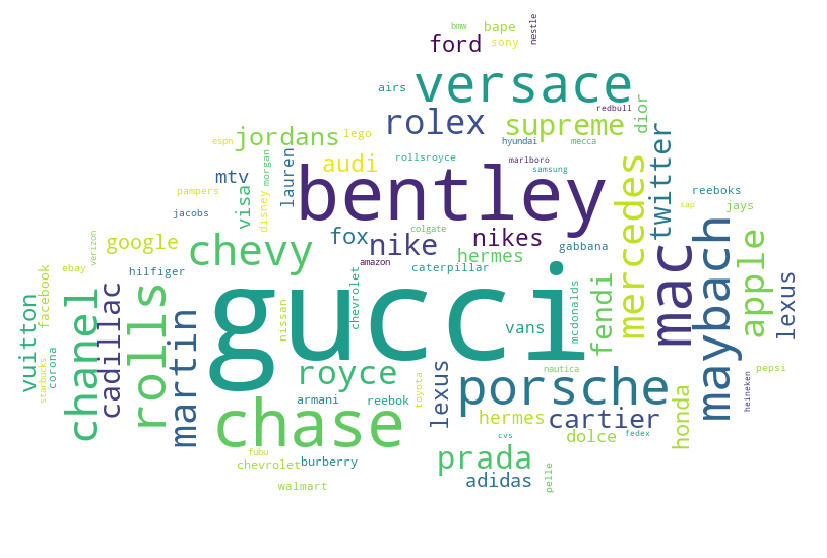

In [33]:
wordcloud = WordCloud(width=1600, height=1000, relative_scaling=.6, background_color = 'white',
                      prefer_horizontal = 0.7,
                      min_font_size = 8,
                      mask = maskArray).generate_from_frequencies(df.filter(items=brand_words).sum())

wordcloud.to_file('brand_words_cloud2.png')

plt.figure(figsize = [20,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

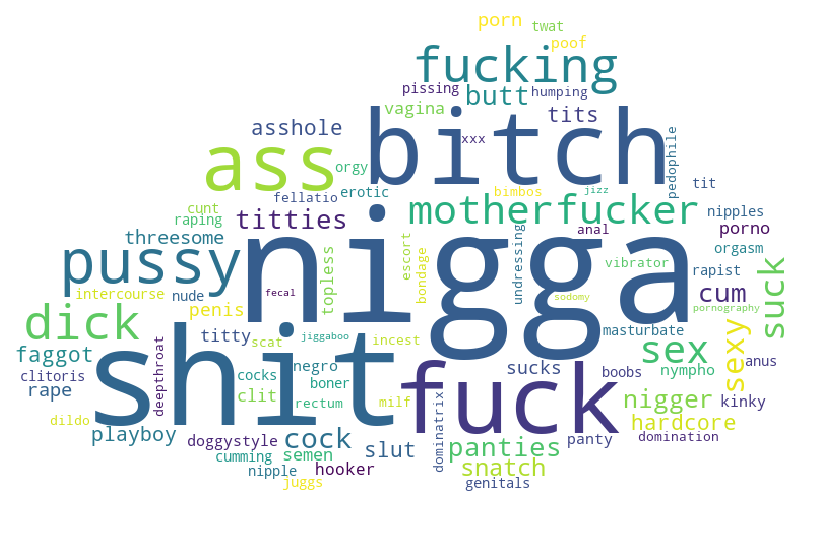

In [34]:
wordcloud = WordCloud(width=1600, height=1000, relative_scaling=.3, background_color = 'white', mask = maskArray).generate_from_frequencies(df.filter(items=profan_words).sum())

wordcloud.to_file('profan_words_cloud.png')

plt.figure(figsize = [20,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

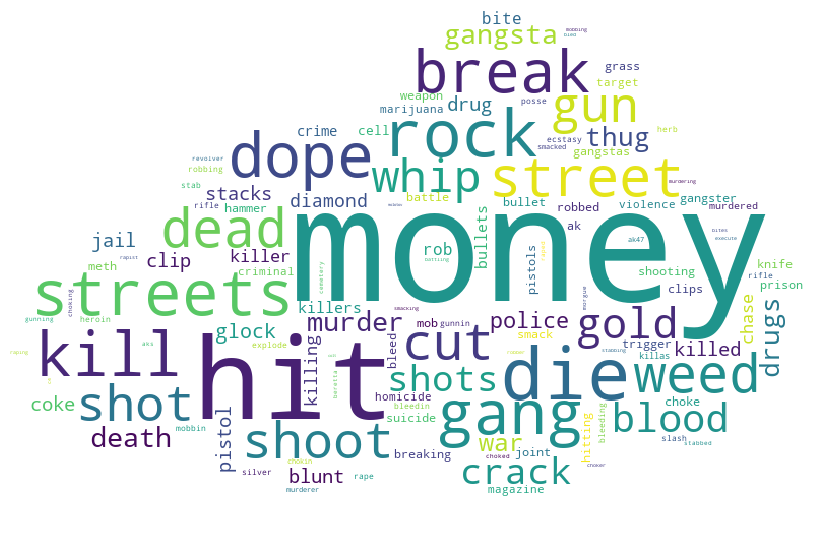

In [35]:
wordcloud = WordCloud(width=1600, height=1000, relative_scaling=.6, background_color = 'white', mask = maskArray).generate_from_frequencies(df.filter(items=gang_words).sum())

wordcloud.to_file('gang_words_cloud.png')

plt.figure(figsize = [20,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [11]:
top100words = df.drop(columns = ['Unnamed: 0', 'URL', 'ARTISTSCORE', 'ARTIST', 'TITLE', 'ALBUM', 'YEAR', 'LYRICS', 'CLEANLYRICS', 'ind']).rename(
    columns = {'fuck' : 'f**k', 'nigga' : 'n***a', 'niggas' : 'n****s', 'shit' : 's**t', 'bitch' : 'b****h',
               'bitches' : 'b******s', 'dick' : 'd**k', 'pussy' : 'p***y', 'fuckin' : 'f****n', 'hoes' : 'h**s'}).sum().sort_values().tail(100)

In [10]:
top100words[80:100]

baby       34114
money      34907
make       35822
let        37349
back       38363
see        38469
one        38879
cause      39302
love       39673
go         43632
f**k       44992
b****h     45590
n****s     46991
s**t       49937
yeah       61376
n***a      74874
know       80616
get        83227
got       116122
like      123459
dtype: int64

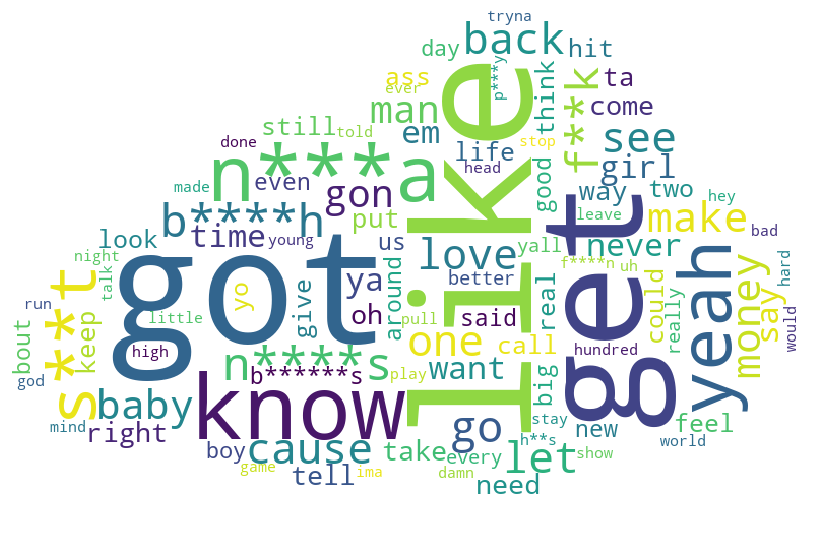

In [13]:
wordcloud = WordCloud(width=1600, height=1000, relative_scaling=.4, background_color = 'white', mask = maskArray).generate_from_frequencies(top100words)

wordcloud.to_file('top100words_cloud.png')

plt.figure(figsize = [20,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [389]:
eminemtop100 = df[df['ARTIST'] == 'eminem'].drop(columns = ['Unnamed: 0', 'URL', 'ARTISTSCORE', 'ARTIST', 'TITLE', 'ALBUM', 'YEAR', 'LYRICS', 'CLEANLYRICS', 'ind']).sum().sort_values().tail(100)

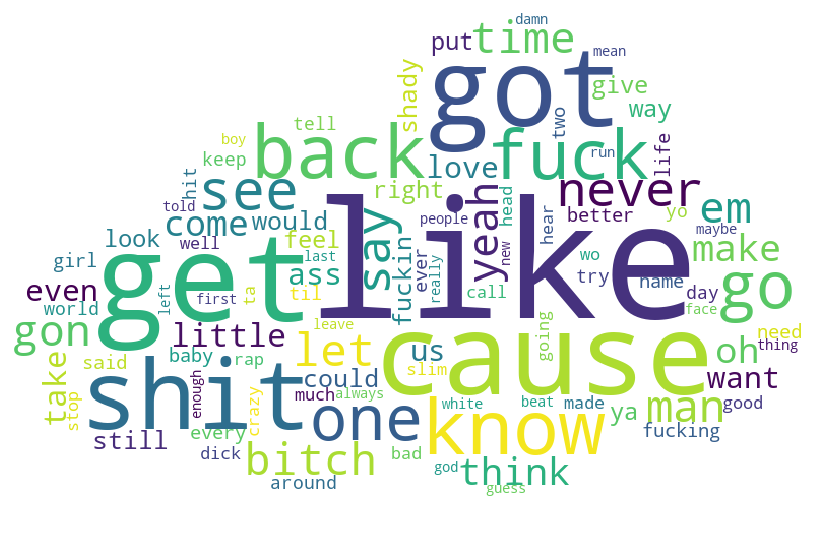

In [391]:
wordcloud = WordCloud(width=1600, height=1000, relative_scaling=.8, background_color = 'white', mask = maskArray).generate_from_frequencies(eminemtop100)

wordcloud.to_file('eminemtop100words_cloud.png')

plt.figure(figsize = [20,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Scatterplots

In [234]:
MDLDF.sort_values('avg_uniquewordpersong', ascending = False).head(10)

,artist,bbscore,song_no,album_no,first_album,unique_words,total_words,r50_unique_words,r50_total_words,charlengs,avg_wordlength,avg_wordpersong,avg_uniquewordpersong
eminem,eminem,327,344,17,1996.0,9280.0,116846.0,3945.0,17202.0,641760,5.492357,339.668605,221.214286
kendricklamar,kendricklamar,247,153,8,2009.0,6466.0,46420.0,3513.0,14119.0,253834,5.468203,303.398693,194.289474
ti,ti,275,266,14,2001.0,7228.0,84688.0,3066.0,15405.0,428245,5.056738,318.375940,189.762452
thegame,thegame,71,412,23,2004.0,9034.0,121700.0,3626.0,14632.0,632503,5.197231,295.388350,188.826303
jayz,jayz,343,283,16,1996.0,8047.0,81680.0,3446.0,14262.0,428690,5.248408,288.621908,185.096085
schoolboyq,schoolboyq,59,86,6,2011.0,4556.0,25554.0,3076.0,13132.0,132236,5.174767,297.139535,182.847059
macklemore&ryanlewis,macklemore&ryanlewis,77,90,6,2005.0,4657.0,24972.0,3409.0,13420.0,137882,5.521464,277.466667,181.528090
ludacris,ludacris,132,167,11,2000.0,6262.0,47268.0,3132.0,13005.0,245900,5.202251,283.041916,179.093750
meekmill,meekmill,77,228,17,2008.0,6282.0,69756.0,2941.0,15269.0,352934,5.059550,305.947368,177.346847
lilwayne,lilwayne,379,579,28,1999.0,10299.0,166674.0,3242.0,14256.0,847622,5.085508,287.865285,174.894180


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


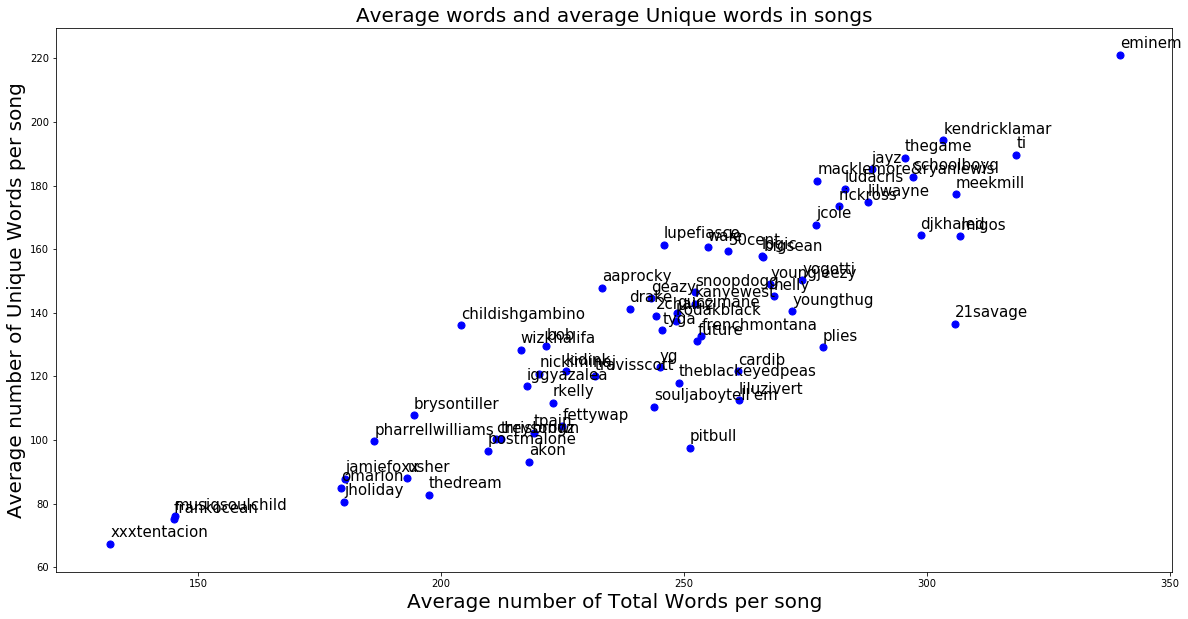

In [247]:
plt.figure(figsize = (20,10))
for i, name in enumerate(MDLDF['artist']):
    x = MDLDF['avg_wordpersong'][i]
    y = MDLDF['avg_uniquewordpersong'][i]
    plt.scatter(x, y, marker = '.', color = 'blue', s=200)
    plt.text(x, y + 2, name, fontsize = 15)
    
plt.title('Average words and average Unique words in songs', fontsize = 20)
plt.xlabel('Average number of Total Words per song', fontsize = 20)
plt.ylabel('Average number of Unique Words per song', fontsize = 20)
plt.show()

In [260]:
pd.DataFrame(MDLDF['avg_uniquewordpersong'] / MDLDF['avg_wordpersong']).head(20)

,0
21savage,0.446661
2chainz,0.569696
50cent,0.614989
aaprocky,0.634187
akon,0.427357
bigsean,0.591393
bob,0.584569
brysontiller,0.554743
cardib,0.465691
childishgambino,0.666582


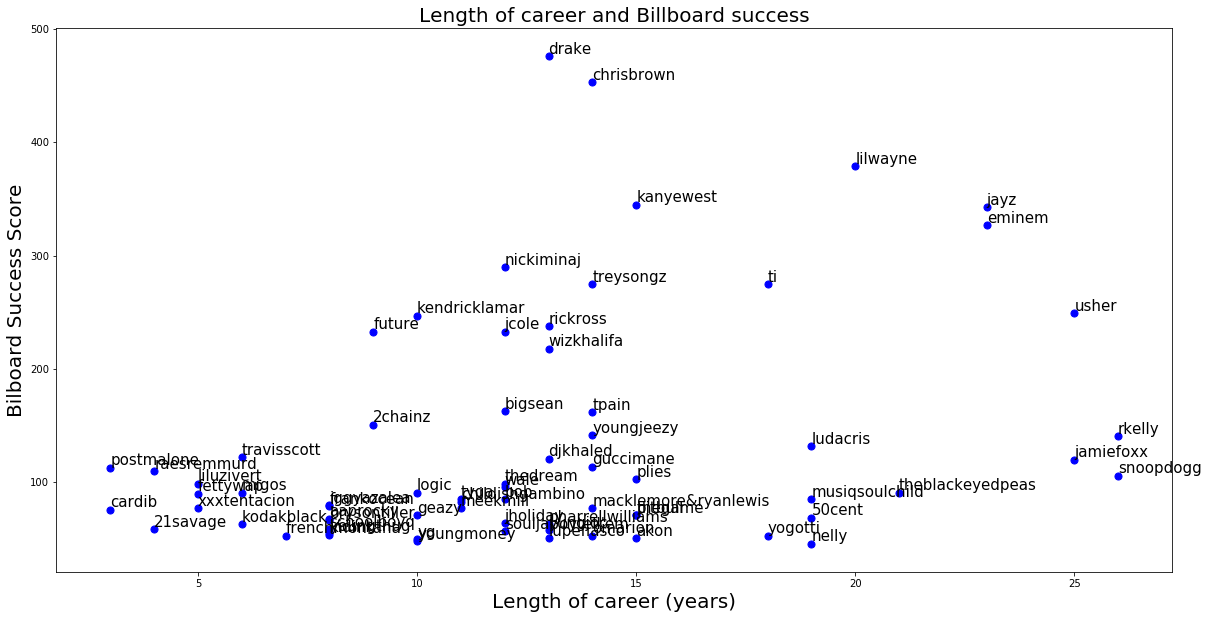

In [238]:
plt.figure(figsize = (20,10))
for i, name in enumerate(MDLDF['artist']):
    x = MDLDF['career'][i]
    y = MDLDF['bbscore'][i]
    plt.scatter(x, y, marker = '.', color = 'blue', s=200)
    plt.text(x, y + 2, name, fontsize = 15)
    
plt.title('Length of career and Billboard success', fontsize = 20)
plt.xlabel('Length of career (years)', fontsize = 20)
plt.ylabel('Bilboard Success Score', fontsize = 20)
plt.show()

In [242]:
MDLDF.head(3)

,artist,bbscore,song_no,album_no,first_album,career,bbscore_per_year,unique_words,total_words,r50_unique_words,r50_total_words,charlengs,avg_wordlength,avg_wordpersong,avg_uniquewordpersong
21savage,21savage,59,99,6,2015.0,4.0,14.750000,3448.0,30278.0,2268.0,13905.0,151534,5.004756,305.838384,136.606061
2chainz,2chainz,151,209,15,2010.0,9.0,16.777778,5927.0,51055.0,2851.0,12386.0,260609,5.104476,244.282297,139.166667
50cent,50cent,69,326,18,2000.0,19.0,3.631579,6897.0,84479.0,2884.0,13716.0,422376,4.999775,259.138037,159.367089


In [246]:
MDLDF[['artist', 'bbscore_per_year']].sort_values('bbscore_per_year', ascending = False).head(20)

,artist,bbscore_per_year
postmalone,postmalone,37.666667
drake,drake,36.615385
chrisbrown,chrisbrown,32.357143
raesremmurd,raesremmurd,27.500000
future,future,25.888889
cardib,cardib,25.333333
kendricklamar,kendricklamar,24.700000
nickiminaj,nickiminaj,24.166667
kanyewest,kanyewest,23.000000
travisscott,travisscott,20.333333


## Sentiments

In [27]:
emolex = pd.read_csv('../CODE/NRC_emotion_lexicon_list.txt',  names=["word", "emotion", "association"], sep='\t')
emolex

,word,emotion,association
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0
...,...,...,...
141815,zoom,negative,0
141816,zoom,positive,0
141817,zoom,sadness,0
141818,zoom,surprise,0


In [509]:
del emolex

In [39]:
emolex.emotion.unique()

array(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust'], dtype=object)

In [28]:
emolex_words = emolex.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_words.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,NaN,0,0,0,0,0,0,0,0,0,0
1,aback,0,0,0,0,0,0,0,0,0,0
2,abacus,0,0,0,0,0,0,0,0,0,1
3,abandon,0,0,0,1,0,1,0,1,0,0
4,abandoned,1,0,0,1,0,1,0,1,0,0


In [449]:
'abhor' in list(emolex_words[emolex_words.anger == 1].word)

True

### Find emotions for a song

In [29]:
def emotionscore(df):
    '''
    takes a df, preferably the result of a group by, and for each row, calculates and returns the sentiment scores
    thus we can get the sentiments for example for each year or artist in the corpus
    '''
    start_time = time.time()
    counter = 0
    
    emotionresult = []
    
    for index, song in df.iterrows():
        songemotions = {'aggcolumn' : song.index,
                        'positive' : 0, 'negative' : 0,
                        'anger' : 0, 'anticipation' : 0, 'disgust' : 0, 'fear' : 0, 'joy' : 0, 'sadness' : 0, 'surprise' : 0, 'trust' : 0}
        for word in song[10:].index:
            if word in list(emolex_words[emolex_words.positive == 1].word):
                songemotions['positive'] += song[word]
            if word in list(emolex_words[emolex_words.negative == 1].word):
                songemotions['negative'] += song[word]
            if word in list(emolex_words[emolex_words.anger == 1].word):
                songemotions['anger'] += song[word]
            if word in list(emolex_words[emolex_words.anticipation == 1].word):
                songemotions['anticipation'] += song[word]
            if word in list(emolex_words[emolex_words.disgust == 1].word):
                songemotions['disgust'] += song[word]
            if word in list(emolex_words[emolex_words.fear == 1].word):
                songemotions['fear'] += song[word]
            if word in list(emolex_words[emolex_words.joy == 1].word):
                songemotions['joy'] += song[word]
            if word in list(emolex_words[emolex_words.sadness == 1].word):
                songemotions['sadness'] += song[word]
            if word in list(emolex_words[emolex_words.surprise == 1].word):
                songemotions['surprise'] += song[word]
            if word in list(emolex_words[emolex_words.trust == 1].word):
                songemotions['trust'] += song[word]
        emotionresult.append(songemotions)
        print("--- %s seconds ---" % (time.time() - start_time))
        counter += 1
    
    return pd.DataFrame(emotionresult)

In [54]:
emotionscore(df[df['ARTIST'] == 'eminem'][64:66])

--- 190.91419291496277 seconds ---
--- 381.8081634044647 seconds ---


,aggcolumn,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,"Index(['Unnamed: 0', 'URL', 'ARTIST', 'ARTISTS...",18,42,27,9,24,14,12,19,7,11
1,"Index(['Unnamed: 0', 'URL', 'ARTIST', 'ARTISTS...",25,40,17,10,13,17,7,14,14,10


#### Written with numpy - turned out to be very slow

In [469]:
positive_words     = np.asarray(emolex_words[emolex_words.positive == 1].word)
negative_words     = np.asarray(emolex_words[emolex_words.negative == 1].word)
anger_words        = np.asarray(emolex_words[emolex_words.anger == 1].word )
anticipation_words = np.asarray(emolex_words[emolex_words.anticipation == 1].word )
disgust_words      = np.asarray(emolex_words[emolex_words.disgust == 1].word)
fear_words         = np.asarray(emolex_words[emolex_words.fear == 1].word )
joy_words          = np.asarray(emolex_words[emolex_words.joy == 1].word )
sadness_words      = np.asarray(emolex_words[emolex_words.sadness == 1].word )
surprise_words     = np.asarray(emolex_words[emolex_words.surprise == 1].word )
trust_words        = np.asarray(emolex_words[emolex_words.trust == 1].word )

In [506]:
del positive_words    
del negative_words    
del anger_words       
del anticipation_words
del disgust_words     
del fear_words        
del joy_words         
del sadness_words     
del surprise_words    
del trust_words       

In [477]:
# Written with Numpy
def emotionscorenp(df):
    start_time = time.time()
    
    emotionresult = []
    
    for index, song in df.iterrows():
        songemotions = {'ARTIST' : song.ARTIST, 'TITLE' : song.TITLE,
                        'positive' : 0, 'negative' : 0,
                        'anger' : 0, 'anticipation' : 0, 'disgust' : 0, 'fear' : 0, 'joy' : 0, 'sadness' : 0, 'surprise' : 0, 'trust' : 0}
        for word in song[10:].index:
            for emotion in emolex.emotion.unique():
                if np.isin(word, eval(emotion + '_words')):
                    songemotions[emotion] += song[word]

        emotionresult.append(songemotions)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    return pd.DataFrame(emotionresult)

In [479]:
emotionscorenp(df[df['ARTIST'] == 'eminem'][64:66])

--- 616.3213422298431 seconds ---
--- 1215.197030544281 seconds ---


,ARTIST,TITLE,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,eminem,"""Drips""",18,41,27,9,23,14,12,18,7,11
1,eminem,"""Without Me""",25,40,17,10,13,17,7,14,14,10


### Sentiment for each year

In [49]:
df.drop(columns = ['Unnamed: 0', 'URL', 'ARTIST', 'ARTISTSCORE', 'ALBUM', 'TITLE', 'LYRICS', 'CLEANLYRICS', 'ind']).groupby('YEAR').sum().index

Float64Index([1985.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0,
              1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0,
              2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0,
              2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0,
              2018.0, 2019.0],
             dtype='float64', name='YEAR')

In [55]:
emotion_years = emotionscore(df.drop(columns = ['Unnamed: 0', 'URL', 'ARTIST', 'ARTISTSCORE', 'ALBUM', 'TITLE', 'LYRICS', 'CLEANLYRICS', 'ind']).groupby('YEAR').sum())
emotion_years

--- 194.43294596672058 seconds ---
--- 400.66208481788635 seconds ---
--- 658.1194019317627 seconds ---
--- 1049.2119483947754 seconds ---
--- 1450.5015993118286 seconds ---
--- 1850.4781312942505 seconds ---
--- 2240.6468987464905 seconds ---
--- 2648.941632270813 seconds ---
--- 3030.7121374607086 seconds ---
--- 3436.903548717499 seconds ---
--- 3838.910448074341 seconds ---
--- 4248.662053823471 seconds ---
--- 4657.000157356262 seconds ---
--- 5061.8577971458435 seconds ---
--- 5477.366411924362 seconds ---
--- 5882.571470975876 seconds ---
--- 6287.695605278015 seconds ---
--- 6675.942494630814 seconds ---
--- 6955.160841464996 seconds ---
--- 7273.368817806244 seconds ---
--- 7583.284931182861 seconds ---
--- 7909.301907300949 seconds ---
--- 8222.640028476715 seconds ---
--- 8531.503036022186 seconds ---
--- 8869.593211650848 seconds ---
--- 9200.547696113586 seconds ---
--- 9534.042609930038 seconds ---
--- 9834.664608955383 seconds ---
--- 10031.691110610962 seconds ---
--- 1

,aggcolumn,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,"Index(['00n9na', '100k', '100s', '10k', '10s',...",342,206,117,125,92,82,143,88,87,171
1,"Index(['00n9na', '100k', '100s', '10k', '10s',...",314,264,142,124,106,144,113,132,87,146
2,"Index(['00n9na', '100k', '100s', '10k', '10s',...",368,754,457,223,345,336,143,226,164,249
3,"Index(['00n9na', '100k', '100s', '10k', '10s',...",603,520,295,228,165,304,277,237,194,309
4,"Index(['00n9na', '100k', '100s', '10k', '10s',...",690,728,390,337,265,348,351,307,248,415
5,"Index(['00n9na', '100k', '100s', '10k', '10s',...",709,1365,746,447,517,760,339,555,280,544
6,"Index(['00n9na', '100k', '100s', '10k', '10s',...",1058,2019,1095,636,821,809,492,802,516,698
7,"Index(['00n9na', '100k', '100s', '10k', '10s',...",2006,2563,1378,1009,858,1327,1131,1101,735,1206
8,"Index(['00n9na', '100k', '100s', '10k', '10s',...",2320,3227,1778,1290,1356,1534,1175,1385,761,1325
9,"Index(['00n9na', '100k', '100s', '10k', '10s',...",2827,3679,1898,1496,1448,1934,1488,1579,1024,1674


In [71]:
emotion_years['YEAR'] = np.sort(metadata[metadata['YEAR'].isna() == False]['YEAR'].unique())

In [74]:
emotion_years.drop(columns = 'aggcolumn').to_csv('emotion_years.csv', sep = ';')

In [10]:
emotion_years = pd.read_csv('emotion_years.csv', sep = ';')
emotion_years.head(3)

,Unnamed: 0,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,YEAR
0,0,342,206,117,125,92,82,143,88,87,171,1985.0
1,1,314,264,142,124,106,144,113,132,87,146,1987.0
2,2,368,754,457,223,345,336,143,226,164,249,1988.0


In [11]:
year_df.shape

(34, 16)

In [13]:
emotion_years.shape

(34, 12)

In [19]:
YEAR_DF = pd.merge(year_df, emotion_years, on='YEAR').drop(columns = ['Unnamed: 0_x', 'Unnamed: 0_y'])

In [21]:
YEAR_DF.to_csv('year_dataframe_FINAL.csv', sep = ';')

### Sentiment for each artist -> to use as a feature

In [30]:
emotion_artists = emotionscore(df.drop(columns = ['Unnamed: 0', 'URL', 'YEAR', 'ARTISTSCORE', 'ALBUM', 'TITLE', 'LYRICS', 'CLEANLYRICS', 'ind']).groupby('ARTIST').sum())
emotion_artists.to_csv('emotion_artists.csv', sep = ';')
emotion_artists.head(5)

--- 190.98090648651123 seconds ---
--- 384.92118191719055 seconds ---
--- 580.3307304382324 seconds ---
--- 780.4939408302307 seconds ---
--- 1012.1127543449402 seconds ---
--- 1265.1485226154327 seconds ---
--- 1480.928034543991 seconds ---
--- 1688.7879755496979 seconds ---
--- 1908.3620183467865 seconds ---
--- 2114.6250851154327 seconds ---
--- 2329.0321435928345 seconds ---
--- 2557.0202882289886 seconds ---
--- 2758.586179971695 seconds ---
--- 2964.562397003174 seconds ---
--- 3177.5924887657166 seconds ---
--- 3418.423236846924 seconds ---
--- 3636.662673473358 seconds ---
--- 3855.682667016983 seconds ---
--- 4079.057217359543 seconds ---
--- 4321.396414041519 seconds ---
--- 4560.919120311737 seconds ---
--- 4807.796985864639 seconds ---
--- 5045.167033672333 seconds ---
--- 5291.104115009308 seconds ---
--- 5529.786082267761 seconds ---
--- 5776.362451076508 seconds ---
--- 6018.054400205612 seconds ---
--- 6262.873269557953 seconds ---
--- 6516.876673936844 seconds ---
--- 

,aggcolumn,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,"Index(['00n9na', '100k', '100s', '10k', '10s',...",2250,3933,2916,1211,1865,2545,1238,1755,1029,1398
1,"Index(['00n9na', '100k', '100s', '10k', '10s',...",3893,4356,2969,2339,2018,2172,2016,1959,1244,2345
2,"Index(['00n9na', '100k', '100s', '10k', '10s',...",8044,12517,7002,5290,4906,7825,4451,5847,3105,4924
3,"Index(['00n9na', '100k', '100s', '10k', '10s',...",6112,8838,5838,3455,3974,4597,3404,3680,2712,3546
4,"Index(['00n9na', '100k', '100s', '10k', '10s',...",492,1122,751,240,555,529,282,373,262,282


In [31]:
emotion_artists.shape

(155, 11)

In [38]:
emotion_artists['artist'] = MDLDF['artist']

In [44]:
emotion_artists.to_csv('emotion_artists.csv', sep = ';')

In [48]:
MDLDF = pd.merge(MDLDF, emotion_artists, on= 'artist').drop(columns = ['Unnamed: 0', 'aggcolumn'])

The emotions per song and per total_words

In [49]:
MDLDF['positive_ps'] = MDLDF['positive'] / MDLDF['song_no']
MDLDF['negative_ps'] = MDLDF['negative'] / MDLDF['song_no']
MDLDF['anger_ps'] = MDLDF['anger'] / MDLDF['song_no']
MDLDF['anticipation_ps'] = MDLDF['anticipation'] / MDLDF['song_no']
MDLDF['disgust_ps'] = MDLDF['disgust'] / MDLDF['song_no']
MDLDF['fear_ps'] = MDLDF['fear'] / MDLDF['song_no']
MDLDF['joy_ps'] = MDLDF['joy'] / MDLDF['song_no']
MDLDF['sadness_ps'] = MDLDF['sadness'] / MDLDF['song_no']
MDLDF['surprise_ps'] = MDLDF['surprise'] / MDLDF['song_no']
MDLDF['trust_ps'] = MDLDF['trust'] / MDLDF['song_no']

MDLDF['positive_percent'] = MDLDF['positive'] / MDLDF['total_words']
MDLDF['negative_percent'] = MDLDF['negative'] / MDLDF['total_words']
MDLDF['anger_percent'] = MDLDF['anger'] / MDLDF['total_words']
MDLDF['anticipation_percent'] = MDLDF['anticipation'] / MDLDF['total_words']
MDLDF['disgust_percent'] = MDLDF['disgust'] / MDLDF['total_words']
MDLDF['fear_percent'] = MDLDF['fear'] / MDLDF['total_words']
MDLDF['joy_percent'] = MDLDF['joy'] / MDLDF['total_words']
MDLDF['sadness_percent'] = MDLDF['sadness'] / MDLDF['total_words']
MDLDF['surprise_percent'] = MDLDF['surprise'] / MDLDF['total_words']
MDLDF['trust_percent'] = MDLDF['trust'] / MDLDF['total_words']

### Sentiment of the entire corpus

Basically summarize one of the dataframes calculated above.

In [152]:
MDLDF['song_no'].sum()

26477

In [157]:
emotion_ps = pd.DataFrame(emotion_years.sum()) / MDLDF['song_no'].sum()

In [159]:
emotion_ps.iloc[1:3,:].iloc[:,0]#.values.tolist()

positive    17.267477
negative    18.590210
Name: 0, dtype: float64

In [160]:
emotion_ps.iloc[3:11,:].iloc[:,0]#.values.tolist()

anger           11.794425
anticipation     9.271632
disgust          8.113872
fear             9.608906
joy              9.755524
sadness          8.304604
surprise         5.749179
trust            9.967595
Name: 0, dtype: float64

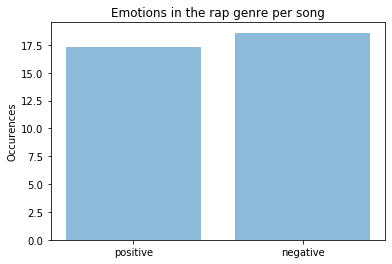

In [164]:
objects = emotion_ps.iloc[1:3,:].iloc[:,0].index.tolist()
y_pos = np.arange(len(objects))
performance = emotion_ps.iloc[1:3,:].iloc[:,0].values.tolist()

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Occurences')
plt.title('Emotions in the rap genre per song')

plt.show()

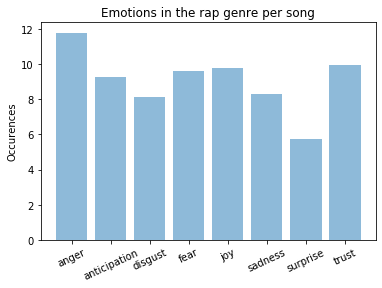

In [163]:
objects = emotion_ps.iloc[3:11,:].iloc[:,0].index.tolist()
y_pos = np.arange(len(objects))
performance = emotion_ps.iloc[3:11,:].iloc[:,0].values.tolist()

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation = 25)
plt.ylabel('Occurences')
plt.title('Emotions in the rap genre per song')

plt.show()

## Topics

In [14]:
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import stopwords

In [15]:
nonsense = ['ai', 'nt', 'da', 'u', 'la', 'dem', 'ya', 'ca', 'na', 'wan', 'gon', 'oh', 'em', 'yo', 'yall', 'ta', 'im',
            'dat', 'wit', 'ha', 'uh', 'n', 'ay', 'hey', 'yea', 'mi', 'yuh', 'di', 'nah']

In [16]:
mostcommon = ['like', 'got', 'get', 'know', 'yeah', 'shit', 'niggas', 'go', 'cause', 'one', 'see', 'back', 'let',
              'make', 'say', 'want', 'right', 'never', 'time', 'right', 'come', 'tell', 'take', 'need',
              'niggas', 'nigga', 'way', 'could', 'man', 'keep', 'big', 'fuckin', 'niggaz', 'lil', 'still', 'two',
              'us', 'would', 'bout', 'hot', 'hello']

In [17]:
mystopwords = stopwords.words('english') + nonsense + mostcommon

In [303]:
mystopwords = stopwords.words('english') + nonsense + mostcommon + ['fuck', 'bitch', 'bitches']

In [18]:
def remove_stop(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in mystopwords:
            new_words.append(word)
    return new_words

In [19]:
tokenlist = [remove_stop(gensim.utils.tokenize(lyric)) for lyric in metadata['CLEANLYRICS'].apply(lambda x : str(x)).tolist()]

In [20]:
dictionary = corpora.Dictionary(tokenlist)

In [21]:
dtm = [dictionary.doc2bow(song) for song in tokenlist]

### Simple LDA models

In [359]:
NUM_TOPICS = 7

ldamodel = gensim.models.ldamodel.LdaModel(dtm, num_topics = NUM_TOPICS, id2word=dictionary,
                                           passes=10, eta = 'auto', random_state = 11)

ldamodel.save('model3.gensim')

topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.060*"bitch" + 0.042*"fuck" + 0.015*"bitches" + 0.014*"pussy" + 0.009*"pull"')
(1, '0.027*"money" + 0.012*"bitch" + 0.009*"fuck" + 0.009*"hundred" + 0.008*"young"')
(2, '0.008*"love" + 0.008*"life" + 0.008*"feel" + 0.007*"think" + 0.006*"said"')
(3, '0.016*"life" + 0.013*"die" + 0.009*"goin" + 0.008*"streets" + 0.008*"nothin"')
(4, '0.046*"baby" + 0.044*"girl" + 0.038*"love" + 0.011*"night" + 0.010*"good"')
(5, '0.031*"party" + 0.030*"shake" + 0.029*"dance" + 0.029*"ah" + 0.017*"turn"')
(6, '0.009*"fuck" + 0.007*"ass" + 0.006*"bitch" + 0.005*"hit" + 0.004*"put"')


In [343]:
topics = ldamodel.print_topics(num_words=8)
for topic in topics:
    print(topic)

(0, '0.020*"love" + 0.011*"life" + 0.009*"feel" + 0.007*"think" + 0.007*"said" + 0.006*"baby" + 0.006*"day" + 0.006*"even"')
(1, '0.057*"girl" + 0.053*"baby" + 0.020*"love" + 0.013*"ooh" + 0.013*"body" + 0.010*"night" + 0.010*"hey" + 0.009*"tonight"')
(2, '0.007*"fuck" + 0.005*"black" + 0.004*"rap" + 0.003*"put" + 0.003*"kill" + 0.003*"new" + 0.003*"game" + 0.003*"die"')
(3, '0.009*"bitch" + 0.008*"ass" + 0.007*"money" + 0.006*"fuck" + 0.005*"real" + 0.005*"boy" + 0.005*"yea" + 0.005*"hit"')
(4, '0.031*"bitch" + 0.024*"fuck" + 0.019*"money" + 0.010*"bitches" + 0.006*"pussy" + 0.006*"young" + 0.006*"hundred" + 0.006*"pull"')


In [ ]:
lda = LdaModel.load(temp_file)

In [239]:
[[(dictionary[id], freq) for id, freq in cp] for cp in dtm[:1]]

[[('auntie', 1),
  ('benjis', 1),
  ('berzerk', 1),
  ('bitch', 5),
  ('bitty', 2),
  ('bought', 2),
  ('bowl', 1),
  ('bullets', 1),
  ('burst', 1),
  ('business', 1),
  ('cali', 1),
  ('car', 1),
  ('chopper', 1),
  ('choppers', 1),
  ('church', 1),
  ('clutching', 1),
  ('cooking', 1),
  ('counting', 1),
  ('cry', 1),
  ('daughter', 3),
  ('die', 1),
  ('door', 1),
  ('dope', 2),
  ('dot', 1),
  ('drop', 1),
  ('every', 2),
  ('everybody', 1),
  ('feds', 1),
  ('flipping', 1),
  ('flirt', 2),
  ('forty', 1),
  ('fuck', 2),
  ('fuckin', 1),
  ('fucking', 6),
  ('fully', 1),
  ('gang', 2),
  ('gangster', 1),
  ('get', 1),
  ('givenchys', 1),
  ('glock', 1),
  ('goddamn', 1),
  ('going', 1),
  ('gon', 1),
  ('guess', 1),
  ('hand', 1),
  ('handle', 1),
  ('heart', 1),
  ('hit', 1),
  ('hitting', 1),
  ('hop', 1),
  ('hotboxing', 1),
  ('huh', 1),
  ('hurt', 1),
  ('hurts', 1),
  ('jaw', 1),
  ('jug', 1),
  ('keep', 1),
  ('kids', 1),
  ('knock', 1),
  ('know', 3),
  ('liar', 1),
  ('li

In [322]:
for i in range(4,9):    
    ldamodel = gensim.models.ldamodel.LdaModel(dtm, num_topics = i, id2word=dictionary,
                                               passes=10, random_state = 11)
    ldamodel.save('iterated_model_' + str(i))
    
    print('------model: ', i, ' ---------------')
    
    topics = ldamodel.print_topics(num_words=5)
    for topic in topics:
        print(topic)

------model:  4  ---------------
(0, '0.009*"money" + 0.006*"ass" + 0.005*"bitch" + 0.005*"hit" + 0.005*"bout"')
(1, '0.030*"love" + 0.029*"baby" + 0.028*"girl" + 0.009*"feel" + 0.008*"night"')
(2, '0.034*"bitch" + 0.026*"fuck" + 0.017*"money" + 0.010*"bitches" + 0.007*"pussy"')
(3, '0.007*"life" + 0.006*"fuck" + 0.004*"real" + 0.004*"god" + 0.004*"think"')
------model:  5  ---------------
(0, '0.009*"fuck" + 0.009*"bout" + 0.008*"bitch" + 0.008*"gettin" + 0.008*"ass"')
(1, '0.031*"love" + 0.031*"baby" + 0.030*"girl" + 0.009*"feel" + 0.008*"night"')
(2, '0.032*"bitch" + 0.024*"fuck" + 0.020*"money" + 0.010*"bitches" + 0.007*"pussy"')
(3, '0.008*"life" + 0.005*"fuck" + 0.004*"god" + 0.004*"real" + 0.004*"people"')
(4, '0.007*"white" + 0.007*"rock" + 0.006*"boy" + 0.006*"hot" + 0.005*"ay"')
------model:  6  ---------------
(0, '0.012*"goin" + 0.011*"gettin" + 0.011*"bout" + 0.011*"talkin" + 0.009*"lookin"')
(1, '0.033*"love" + 0.033*"baby" + 0.032*"girl" + 0.009*"feel" + 0.009*"night"')


In [360]:
for i in range(4,9):    
    ldamodel = gensim.models.ldamodel.LdaModel(dtm, num_topics = i, id2word=dictionary,
                                               passes=10, random_state = 11)
    ldamodel.save('iterated_modelB_' + str(i))
    
    print('------model: ', i, ' ---------------')
    
    topics = ldamodel.print_topics(num_words=5)
    for topic in topics:
        print(topic)

------model:  4  ---------------
(0, '0.030*"bitch" + 0.021*"fuck" + 0.019*"money" + 0.009*"bitches" + 0.006*"hundred"')
(1, '0.037*"girl" + 0.034*"baby" + 0.012*"love" + 0.009*"body" + 0.007*"put"')
(2, '0.021*"love" + 0.009*"life" + 0.009*"baby" + 0.009*"feel" + 0.007*"think"')
(3, '0.007*"fuck" + 0.004*"game" + 0.004*"black" + 0.004*"real" + 0.004*"ass"')
------model:  5  ---------------
(0, '0.051*"bitch" + 0.032*"fuck" + 0.012*"bitches" + 0.012*"pussy" + 0.008*"ass"')
(1, '0.025*"money" + 0.012*"bitch" + 0.012*"fuck" + 0.008*"hundred" + 0.008*"young"')
(2, '0.010*"life" + 0.006*"feel" + 0.006*"love" + 0.005*"think" + 0.005*"god"')
(3, '0.006*"fuck" + 0.006*"ass" + 0.004*"hit" + 0.004*"put" + 0.004*"game"')
(4, '0.038*"baby" + 0.037*"girl" + 0.034*"love" + 0.010*"night" + 0.009*"good"')
------model:  6  ---------------
(0, '0.055*"bitch" + 0.038*"fuck" + 0.014*"bitches" + 0.013*"pussy" + 0.009*"ass"')
(1, '0.025*"money" + 0.011*"bitch" + 0.009*"fuck" + 0.008*"hundred" + 0.007*"boy"

### LDA Mallet Model

In [22]:
mallet_path = r'C:\Users\HP\Documents\00_EGYETEM\SZAKDOLGOZAT\CODE\mallet-2.0.8\bin\mallet'

In [23]:
os.environ.update({'MALLET_HOME':r'C:/Users/HP/Documents/00_EGYETEM/SZAKDOLGOZAT/CODE/mallet-2.0.8/'})

In [24]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=dtm, num_topics=7, id2word=dictionary)

In [25]:
ldamallet.show_topics(formatted = False)

[(0,
  [('black', 0.008257920055771608),
   ('rap', 0.007193001372135169),
   ('rock', 0.006355541048110397),
   ('music', 0.0058075731817732006),
   ('flow', 0.0054826326680422486),
   ('people', 0.005438322597988028),
   ('king', 0.0035728686487053337),
   ('beat', 0.003528558578651113),
   ('sick', 0.0034488004525535156),
   ('sound', 0.003311439235385431)]),
 (1,
  [('baby', 0.0570379076793438),
   ('love', 0.05209735316688708),
   ('girl', 0.0504371262190463),
   ('night', 0.017207508305314565),
   ('good', 0.014234815945535193),
   ('body', 0.013622889396784209),
   ('give', 0.013460712142060587),
   ('ooh', 0.011436004353706921),
   ('girls', 0.010312467083869048),
   ('tonight', 0.008383059331796273)]),
 (2,
  [('life', 0.026628347723672317),
   ('feel', 0.01882632339971413),
   ('world', 0.013254041321422943),
   ('love', 0.011772154348481204),
   ('god', 0.011092034581048987),
   ('mind', 0.010305473305299129),
   ('day', 0.009578353391337044),
   ('heart', 0.0089867044879610

In [27]:
ldamallet.save('ldamallet.gensim')

#### Other models

In [382]:
ldamallet5 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=dtm, num_topics=5, id2word=dictionary)

In [383]:
ldamallet5.show_topics(formatted = False)

[(0,
  [('life', 0.019469053382725282),
   ('feel', 0.010256073339970587),
   ('god', 0.009543495070070197),
   ('world', 0.009390871922900041),
   ('day', 0.009170528571356374),
   ('people', 0.007469437467466506),
   ('made', 0.007333997058719482),
   ('live', 0.00729154558732116),
   ('mind', 0.0062403662955532084),
   ('wo', 0.0056167339657254905)]),
 (1,
  [('money', 0.036871796334261756),
   ('hundred', 0.012928207256906927),
   ('boy', 0.012865889918005169),
   ('young', 0.011959647938721988),
   ('real', 0.008797307045978578),
   ('call', 0.007562578754857319),
   ('white', 0.00731119694708413),
   ('rich', 0.006209553142431031),
   ('cash', 0.0059655649172394055),
   ('dope', 0.0058303679786050845)]),
 (2,
  [('love', 0.04622033760091332),
   ('baby', 0.039742081289826536),
   ('girl', 0.03514288044174695),
   ('good', 0.014776155916170595),
   ('night', 0.013444624363649071),
   ('give', 0.013325800025628779),
   ('show', 0.009644575435980476),
   ('put', 0.009561864377162428

In [384]:
ldamallet6 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=dtm, num_topics=6, id2word=dictionary)

In [385]:
ldamallet6.show_topics(formatted = False)

[(0,
  [('fuck', 0.018713456102613525),
   ('ass', 0.013544528288764474),
   ('real', 0.012585755517911168),
   ('game', 0.00825513291173826),
   ('gettin', 0.008229052305277224),
   ('hood', 0.007550956537290299),
   ('hit', 0.007526117864470266),
   ('goin', 0.007317473012781981),
   ('ima', 0.007065360483658637),
   ('ride', 0.007004505735249554)]),
 (1,
  [('love', 0.048293890640747315),
   ('baby', 0.04815414974013839),
   ('girl', 0.042581452006764026),
   ('give', 0.016104080151992932),
   ('night', 0.015433606133919775),
   ('good', 0.01469114437916929),
   ('body', 0.01150109957738964),
   ('show', 0.009745163412162257),
   ('put', 0.009258187546403859),
   ('ooh', 0.009059162627354775)]),
 (2,
  [('high', 0.014117140559071347),
   ('call', 0.011344909989775036),
   ('put', 0.01025841668690812),
   ('fucking', 0.010107151220377785),
   ('fly', 0.008907208817613118),
   ('white', 0.008539226480765287),
   ('city', 0.007737810403282461),
   ('smoke', 0.007257833442176594),
   ('

In [386]:
ldamallet8 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=dtm, num_topics=8, id2word=dictionary)

In [387]:
ldamallet8.show_topics(formatted = False)

[(0,
  [('fuck', 0.08177048214996466),
   ('bitch', 0.07518042684511553),
   ('bitches', 0.027859613284068458),
   ('ass', 0.026999961833656536),
   ('bad', 0.019399407149464854),
   ('pussy', 0.01699856240106284),
   ('hoes', 0.016858619141693457),
   ('hit', 0.013023810345986991),
   ('dick', 0.012832978628665104),
   ('head', 0.011013716256863126)]),
 (1,
  [('real', 0.016466390813885953),
   ('hard', 0.013715679236366391),
   ('fucking', 0.012891367635758889),
   ('tryna', 0.011520521210240945),
   ('call', 0.010766555676206074),
   ('work', 0.010400395380969044),
   ('day', 0.009974711490939788),
   ('talking', 0.009790729470672905),
   ('put', 0.009491307751415039),
   ('coming', 0.008219667317217471)]),
 (2,
  [('life', 0.030262039537664157),
   ('feel', 0.016101943890640638),
   ('world', 0.014557577528605342),
   ('god', 0.013976279915224814),
   ('mind', 0.010581187638156376),
   ('live', 0.010145999965436359),
   ('people', 0.009704527994193309),
   ('heart', 0.0090383923507

In [397]:
ldamallet7 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=dtm, num_topics=7, id2word=dictionary,
                                               random_seed = 11)

In [398]:
ldamallet7.show_topics(formatted = False)

[(0,
  [('money', 0.03958942959976446),
   ('real', 0.017719480613121667),
   ('high', 0.01352244527630733),
   ('fucking', 0.011496031292999333),
   ('city', 0.00949966051181599),
   ('hard', 0.009328414259705457),
   ('young', 0.008870255427304463),
   ('talking', 0.008152222896525204),
   ('put', 0.008114668893869385),
   ('fuck', 0.007718098625823935)]),
 (1,
  [('life', 0.02688068503741414),
   ('god', 0.013494768160720316),
   ('world', 0.012743973406793995),
   ('feel', 0.012215067808767832),
   ('day', 0.010392506565965274),
   ('live', 0.009722652510417627),
   ('made', 0.009644502870603734),
   ('people', 0.008663445785082909),
   ('die', 0.007378163316000859),
   ('mind', 0.007330715320399568)]),
 (2,
  [('bitch', 0.044556276680664975),
   ('fuck', 0.013786832332627633),
   ('pull', 0.012524901953979107),
   ('money', 0.011875195224377884),
   ('boy', 0.010253704924860305),
   ('hundred', 0.010137090896470344),
   ('bitches', 0.0096303751778711),
   ('rich', 0.00896539756359

In [408]:
ldamallet9 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=dtm, num_topics=9, id2word=dictionary,
                                               random_seed = 11)

In [409]:
ldamallet9.show_topics(formatted = False)

[(0,
  [('god', 0.015905190845629684),
   ('people', 0.013680093150512494),
   ('black', 0.007645302396700487),
   ('world', 0.007497209372067064),
   ('music', 0.006699358201854495),
   ('made', 0.004813023300586263),
   ('hear', 0.004296548877177199),
   ('free', 0.004233609341707994),
   ('win', 0.004096623293922077),
   ('coming', 0.004079962828650817)]),
 (1,
  [('money', 0.06779466801840382),
   ('cash', 0.011711171058841351),
   ('hundred', 0.010743979817165896),
   ('gucci', 0.010122491469101347),
   ('rich', 0.009609763581948094),
   ('check', 0.009320383069880539),
   ('diamonds', 0.009314556616617432),
   ('gang', 0.009306788012266627),
   ('bag', 0.009131994414373472),
   ('bitch', 0.009100919996970245)]),
 (2,
  [('fuck', 0.08760039329835184),
   ('bitch', 0.0796409692273245),
   ('bitches', 0.028298011117493017),
   ('ass', 0.02819092493258438),
   ('bad', 0.019018506439773757),
   ('pussy', 0.018210492499099503),
   ('real', 0.017832770319603588),
   ('hoes', 0.017636121

#### Testing the coherence of these four models

In [28]:
from gensim.models import CoherenceModel

In [29]:
CoherenceModel(model=ldamallet,  texts=tokenlist, dictionary=dictionary, coherence='c_v').get_coherence()

0.39291313549251455

In [406]:
coherence_model_ldamallet  = CoherenceModel(model=ldamallet,  texts=tokenlist, dictionary=dictionary, coherence='c_v')
coherence_model_ldamallet5 = CoherenceModel(model=ldamallet5, texts=tokenlist, dictionary=dictionary, coherence='c_v')
coherence_model_ldamallet6 = CoherenceModel(model=ldamallet6, texts=tokenlist, dictionary=dictionary, coherence='c_v')
coherence_model_ldamallet8 = CoherenceModel(model=ldamallet8, texts=tokenlist, dictionary=dictionary, coherence='c_v')

In [407]:
print('\nCoherence Score: ', ldamallet, ' : ', coherence_model_ldamallet.get_coherence())
print('\nCoherence Score: ', ldamallet5, ' : ', coherence_model_ldamallet5.get_coherence())
print('\nCoherence Score: ', ldamallet6, ' : ', coherence_model_ldamallet6.get_coherence())
print('\nCoherence Score: ', ldamallet8, ' : ', coherence_model_ldamallet8.get_coherence())


Coherence Score:  <gensim.models.wrappers.ldamallet.LdaMallet object at 0x000001C1BFBC1FD0>  :  0.3900483381301521

Coherence Score:  <gensim.models.wrappers.ldamallet.LdaMallet object at 0x000001C163EFBFD0>  :  0.3713122191439676

Coherence Score:  <gensim.models.wrappers.ldamallet.LdaMallet object at 0x000001C15F33CF70>  :  0.3636137056760145

Coherence Score:  <gensim.models.wrappers.ldamallet.LdaMallet object at 0x000001C163EFB130>  :  0.39100482738318554


In [411]:
coherence_model_ldamallet9 = CoherenceModel(model=ldamallet9, texts=tokenlist, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score for ldamallet9 :', coherence_model_ldamallet8.get_coherence())


Coherence Score for ldamallet9 : 0.39100482738318554


### The chosen model: lmdamallet

#### Visualization DON'T RUN, CRASHES

In [414]:
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
#pyLDAvis.enable_notebook()
#modeltovis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
#vis = pyLDAvis.gensim.prepare(modeltovis, dtm, dictionary)
#vis

#### Putting the documents into topics

In [32]:
def format_topics_sentences(ldamodel=ldamallet, corpus=dtm, texts=tokenlist):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [33]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=dtm, texts=tokenlist)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [41]:
# Show
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.5114,"fuck, bitch, bitches, ass, bad, hoes, pussy, f...","[skirt, skirt, skirt, skirt, skirt, skirt, ski..."
1,1,4.0,0.3244,"money, hundred, boy, young, pull, rich, cash, ...","[pull, trap, scatter, roaches, clothes, french..."
2,2,4.0,0.3836,"money, hundred, boy, young, pull, rich, cash, ...","[gang, gang, bitch, hang, gang, give, fuck, st..."
3,3,4.0,0.3776,"money, hundred, boy, young, pull, rich, cash, ...","[motherfucking, picky, fucking, dipping, tinte..."
4,4,6.0,0.5098,"fuck, bitch, bitches, ass, bad, hoes, pussy, f...","[pinky, ring, slaughter, daughter, quarter, sl..."


In [ ]:
# Merge it to the song metadata df

In [68]:
metadata = pd.merge(metadata.rename(columns = {'Unnamed: 0' : 'Document_No'}), df_dominant_topic, on= 'Document_No')

In [59]:
metadata.head(5)

,Document_No,URL,ARTIST,ARTISTSCORE,ALBUM,TITLE,YEAR,LYRICS,CLEANLYRICS,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,https://www.azlyrics.com/lyrics/21savage/skirt...,21savage,59.0,"""The Slaughter Tape""","""Skirtt Skirtt""",2015.0,Skirt skirt\nSkirt skirt\n\nSkirt skirt\nSkirt...,skirt skirt skirt skirt skirt skirt skirt skir...,6.0,0.5114,"fuck, bitch, bitches, ass, bad, hoes, pussy, f...","[skirt, skirt, skirt, skirt, skirt, skirt, ski..."
1,1,https://www.azlyrics.com/lyrics/21savage/pimp....,21savage,59.0,"""The Slaughter Tape""","""Pimp""",2015.0,Pull up in yo\nTrap niggas scatter like roache...,pull yo trap niggas scatter like roaches cloth...,4.0,0.3244,"money, hundred, boy, young, pull, rich, cash, ...","[pull, trap, scatter, roaches, clothes, french..."
2,2,https://www.azlyrics.com/lyrics/21savage/gang....,21savage,59.0,"""The Slaughter Tape""","""Gang""",2015.0,Gang [x14]\n\nGang [x8]\nBitch you can't hang ...,gang gang bitch ca nt hang gang nt give fuck b...,4.0,0.3836,"money, hundred, boy, young, pull, rich, cash, ...","[gang, gang, bitch, hang, gang, give, fuck, st..."
3,3,https://www.azlyrics.com/lyrics/21savage/picky...,21savage,59.0,"""The Slaughter Tape""","""Picky""",2015.0,I'm so motherfucking picky\nShe ain't fucking ...,motherfucking picky ai nt fucking dipping ai n...,4.0,0.3776,"money, hundred, boy, young, pull, rich, cash, ...","[motherfucking, picky, fucking, dipping, tinte..."
4,4,https://www.azlyrics.com/lyrics/21savage/slaug...,21savage,59.0,"""The Slaughter Tape""","""Slaughter Your Daughter""",2015.0,[21 Savage:]\nMy pinky ring (slaughter your da...,pinky ring slaughter daughter quarter slaughte...,6.0,0.5098,"fuck, bitch, bitches, ass, bad, hoes, pussy, f...","[pinky, ring, slaughter, daughter, quarter, sl..."


In [69]:
dummiesdf = pd.get_dummies(metadata['Dominant_Topic'])
dummiesdf['Document_No'] = metadata['Document_No']
dummiesdf.head(5)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,Document_No
0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,1
2,0,0,0,0,1,0,0,2
3,0,0,0,0,1,0,0,3
4,0,0,0,0,0,0,1,4


In [70]:
metadata = pd.merge(metadata, dummiesdf, on = 'Document_No')
metadata.head(3)

,Document_No,URL,ARTIST,ARTISTSCORE,ALBUM,TITLE,YEAR,LYRICS,CLEANLYRICS,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,0.0,1.0,2.0,3.0,4.0,5.0,6.0
0,0,https://www.azlyrics.com/lyrics/21savage/skirt...,21savage,59.0,"""The Slaughter Tape""","""Skirtt Skirtt""",2015.0,Skirt skirt\nSkirt skirt\n\nSkirt skirt\nSkirt...,skirt skirt skirt skirt skirt skirt skirt skir...,6.0,0.5114,"fuck, bitch, bitches, ass, bad, hoes, pussy, f...","[skirt, skirt, skirt, skirt, skirt, skirt, ski...",0,0,0,0,0,0,1
1,1,https://www.azlyrics.com/lyrics/21savage/pimp....,21savage,59.0,"""The Slaughter Tape""","""Pimp""",2015.0,Pull up in yo\nTrap niggas scatter like roache...,pull yo trap niggas scatter like roaches cloth...,4.0,0.3244,"money, hundred, boy, young, pull, rich, cash, ...","[pull, trap, scatter, roaches, clothes, french...",0,0,0,0,1,0,0
2,2,https://www.azlyrics.com/lyrics/21savage/gang....,21savage,59.0,"""The Slaughter Tape""","""Gang""",2015.0,Gang [x14]\n\nGang [x8]\nBitch you can't hang ...,gang gang bitch ca nt hang gang nt give fuck b...,4.0,0.3836,"money, hundred, boy, young, pull, rich, cash, ...","[gang, gang, bitch, hang, gang, give, fuck, st...",0,0,0,0,1,0,0


In [71]:
metadata.rename(columns = {0.0 : 'topic_music', 1.0 : 'topic_love', 2.0 : 'topic_life',
                            3.0 : 'topic_real', 4.0 : 'topic_money', 5.0 : 'topic_street', 6.0 : 'topic_sex'}, inplace = True)
metadata.head(5)

,Document_No,URL,ARTIST,ARTISTSCORE,ALBUM,TITLE,YEAR,LYRICS,CLEANLYRICS,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,topic_music,topic_love,topic_life,topic_real,topic_money,topic_street,topic_sex
0,0,https://www.azlyrics.com/lyrics/21savage/skirt...,21savage,59.0,"""The Slaughter Tape""","""Skirtt Skirtt""",2015.0,Skirt skirt\nSkirt skirt\n\nSkirt skirt\nSkirt...,skirt skirt skirt skirt skirt skirt skirt skir...,6.0,0.5114,"fuck, bitch, bitches, ass, bad, hoes, pussy, f...","[skirt, skirt, skirt, skirt, skirt, skirt, ski...",0,0,0,0,0,0,1
1,1,https://www.azlyrics.com/lyrics/21savage/pimp....,21savage,59.0,"""The Slaughter Tape""","""Pimp""",2015.0,Pull up in yo\nTrap niggas scatter like roache...,pull yo trap niggas scatter like roaches cloth...,4.0,0.3244,"money, hundred, boy, young, pull, rich, cash, ...","[pull, trap, scatter, roaches, clothes, french...",0,0,0,0,1,0,0
2,2,https://www.azlyrics.com/lyrics/21savage/gang....,21savage,59.0,"""The Slaughter Tape""","""Gang""",2015.0,Gang [x14]\n\nGang [x8]\nBitch you can't hang ...,gang gang bitch ca nt hang gang nt give fuck b...,4.0,0.3836,"money, hundred, boy, young, pull, rich, cash, ...","[gang, gang, bitch, hang, gang, give, fuck, st...",0,0,0,0,1,0,0
3,3,https://www.azlyrics.com/lyrics/21savage/picky...,21savage,59.0,"""The Slaughter Tape""","""Picky""",2015.0,I'm so motherfucking picky\nShe ain't fucking ...,motherfucking picky ai nt fucking dipping ai n...,4.0,0.3776,"money, hundred, boy, young, pull, rich, cash, ...","[motherfucking, picky, fucking, dipping, tinte...",0,0,0,0,1,0,0
4,4,https://www.azlyrics.com/lyrics/21savage/slaug...,21savage,59.0,"""The Slaughter Tape""","""Slaughter Your Daughter""",2015.0,[21 Savage:]\nMy pinky ring (slaughter your da...,pinky ring slaughter daughter quarter slaughte...,6.0,0.5098,"fuck, bitch, bitches, ass, bad, hoes, pussy, f...","[pinky, ring, slaughter, daughter, quarter, sl...",0,0,0,0,0,0,1


In [76]:
metadata.to_csv('songs_dataframe_FINAL.csv', sep = ';')

#### Topics per year

In [98]:
year_df.shape

(34, 40)

In [100]:
year_topics.shape

(34, 8)

In [105]:
year_topics = metadata.drop(columns = ['URL', 'ARTIST', 'ARTISTSCORE', 'ALBUM', 'TITLE', 'LYRICS', 'CLEANLYRICS', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Document_No']).groupby('YEAR').sum()
year_topics['Unnamed: 0'] = np.linspace(0,33,34, dtype = int)
year_topics.head(5)

,topic_music,topic_love,topic_life,topic_real,topic_money,topic_street,topic_sex,Unnamed: 0
YEAR,,,,,,,,
1985.0,6.0,1.0,3.0,0.0,0.0,0.0,0.0,0
1987.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1988.0,3.0,0.0,0.0,0.0,0.0,15.0,1.0,2
1989.0,10.0,1.0,4.0,1.0,0.0,3.0,0.0,3
1990.0,9.0,2.0,0.0,2.0,0.0,13.0,2.0,4


In [113]:
year_df = pd.merge(year_df, year_topics, on = 'Unnamed: 0')

year_df['topic_music_percent'] = year_df['topic_music'] /  year_df['song_no']
year_df['topic_love_percent'] =  year_df['topic_love'] /   year_df['song_no']
year_df['topic_life_percent'] =  year_df['topic_life'] /   year_df['song_no']
year_df['topic_real_percent'] =  year_df['topic_real'] /   year_df['song_no']
year_df['topic_money_percent'] = year_df['topic_money'] /  year_df['song_no']
year_df['topic_street_percent'] =year_df['topic_street'] / year_df['song_no']
year_df['topic_sex_percent'] =   year_df['topic_sex'] /    year_df['song_no']

year_df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True)

In [115]:
year_df.to_csv('year_dataframe_FINAL.csv', sep = ';')

#### Topics per artist

In [118]:
MDLDF.head(3)

,Unnamed: 0,artist,bbscore,votescore,black,male,song_no,album_no,first_album,career,bbscore_per_year,unique_words,total_words,avg_wordpersong,avg_uniquewordpersong,charlengs,avg_wordlength,r50_unique_words,r50_total_words,profan_words,gang_words,brand_words,profan_percent,gang_percent,brand_percent,bb100,vote100,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,positive_ps,negative_ps,anger_ps,anticipation_ps,disgust_ps,fear_ps,joy_ps,sadness_ps,surprise_ps,trust_ps,positive_percent,negative_percent,anger_percent,anticipation_percent,disgust_percent,fear_percent,joy_percent,sadness_percent,surprise_percent,trust_percent,profan_ps,gang_ps,brand_ps
0,0,21savage,59.0,NaN,1.0,1,99,6,2015.0,4.0,14.750000,3579,30458,307.656566,138.050505,151534,4.975179,2324,13974,2461,1598,113,0.080800,0.052466,0.003710,12.394958,0.0,2250,3933,2916,1211,1865,2545,1238,1755,1029,1398,22.727273,39.727273,29.454545,12.232323,18.838384,25.707071,12.505051,17.727273,10.393939,14.121212,0.073872,0.129129,0.095738,0.039760,0.061232,0.083558,0.040646,0.057620,0.033784,0.045899,24.858586,16.141414,1.141414
1,1,2chainz,151.0,11.0,1.0,1,209,15,2010.0,9.0,16.777778,6341,51564,246.717703,141.449495,260609,5.054088,2977,12522,2455,1493,268,0.047611,0.028954,0.005197,31.722689,22.0,3893,4356,2969,2339,2018,2172,2016,1959,1244,2345,18.626794,20.842105,14.205742,11.191388,9.655502,10.392344,9.645933,9.373206,5.952153,11.220096,0.075498,0.084478,0.057579,0.045361,0.039136,0.042122,0.039097,0.037992,0.024125,0.045477,11.746411,7.143541,1.282297
2,2,2pac,NaN,48.0,1.0,1,269,14,1991.0,28.0,NaN,7088,101964,379.048327,218.122951,532042,5.217940,3430,19080,3986,4955,73,0.039092,0.048596,0.000716,0.000000,96.0,8044,12517,7002,5290,4906,7825,4451,5847,3105,4924,29.903346,46.531599,26.029740,19.665428,18.237918,29.089219,16.546468,21.736059,11.542751,18.304833,0.078891,0.122759,0.068671,0.051881,0.048115,0.076743,0.043653,0.057344,0.030452,0.048292,14.817844,18.420074,0.271375


In [133]:
artist_topics = metadata.drop(columns = ['URL', 'YEAR', 'ARTISTSCORE', 'ALBUM', 'TITLE', 'LYRICS', 'CLEANLYRICS', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Document_No', 'Unnamed: 0']).groupby('ARTIST').sum()
artist_topics['Unnamed: 0'] = np.linspace(0,154,155, dtype = int)
artist_topics.head(3)

,topic_music,topic_love,topic_life,topic_real,topic_money,topic_street,topic_sex,Unnamed: 0
ARTIST,,,,,,,,
21savage,0,7,8,4,49,7,29,0
2chainz,14,18,20,25,100,9,29,1
2pac,13,13,76,4,0,159,4,2


In [134]:
MDLDF = pd.merge(MDLDF, artist_topics, on = 'Unnamed: 0')

MDLDF['topic_music_percent'] = MDLDF['topic_music'] /  MDLDF['song_no']
MDLDF['topic_love_percent'] =  MDLDF['topic_love'] /   MDLDF['song_no']
MDLDF['topic_life_percent'] =  MDLDF['topic_life'] /   MDLDF['song_no']
MDLDF['topic_real_percent'] =  MDLDF['topic_real'] /   MDLDF['song_no']
MDLDF['topic_money_percent'] = MDLDF['topic_money'] /  MDLDF['song_no']
MDLDF['topic_street_percent'] =MDLDF['topic_street'] / MDLDF['song_no']
MDLDF['topic_sex_percent'] =   MDLDF['topic_sex'] /    MDLDF['song_no']

MDLDF.drop(columns = 'Unnamed: 0', inplace = True)

MDLDF.head(3)

,artist,bbscore,votescore,black,male,song_no,album_no,first_album,career,bbscore_per_year,unique_words,total_words,avg_wordpersong,avg_uniquewordpersong,charlengs,avg_wordlength,r50_unique_words,r50_total_words,profan_words,gang_words,brand_words,profan_percent,gang_percent,brand_percent,bb100,vote100,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,positive_ps,negative_ps,anger_ps,anticipation_ps,disgust_ps,fear_ps,joy_ps,sadness_ps,surprise_ps,trust_ps,positive_percent,negative_percent,anger_percent,anticipation_percent,disgust_percent,fear_percent,joy_percent,sadness_percent,surprise_percent,trust_percent,profan_ps,gang_ps,brand_ps,topic_music,topic_love,topic_life,topic_real,topic_money,topic_street,topic_sex,topic_music_percent,topic_love_percent,topic_life_percent,topic_real_percent,topic_money_percent,topic_street_percent,topic_sex_percent
0,21savage,59.0,NaN,1.0,1,99,6,2015.0,4.0,14.750000,3579,30458,307.656566,138.050505,151534,4.975179,2324,13974,2461,1598,113,0.080800,0.052466,0.003710,12.394958,0.0,2250,3933,2916,1211,1865,2545,1238,1755,1029,1398,22.727273,39.727273,29.454545,12.232323,18.838384,25.707071,12.505051,17.727273,10.393939,14.121212,0.073872,0.129129,0.095738,0.039760,0.061232,0.083558,0.040646,0.057620,0.033784,0.045899,24.858586,16.141414,1.141414,0,7,8,4,49,7,29,0.000000,0.070707,0.080808,0.040404,0.494949,0.070707,0.292929
1,2chainz,151.0,11.0,1.0,1,209,15,2010.0,9.0,16.777778,6341,51564,246.717703,141.449495,260609,5.054088,2977,12522,2455,1493,268,0.047611,0.028954,0.005197,31.722689,22.0,3893,4356,2969,2339,2018,2172,2016,1959,1244,2345,18.626794,20.842105,14.205742,11.191388,9.655502,10.392344,9.645933,9.373206,5.952153,11.220096,0.075498,0.084478,0.057579,0.045361,0.039136,0.042122,0.039097,0.037992,0.024125,0.045477,11.746411,7.143541,1.282297,14,18,20,25,100,9,29,0.066986,0.086124,0.095694,0.119617,0.478469,0.043062,0.138756
2,2pac,NaN,48.0,1.0,1,269,14,1991.0,28.0,NaN,7088,101964,379.048327,218.122951,532042,5.217940,3430,19080,3986,4955,73,0.039092,0.048596,0.000716,0.000000,96.0,8044,12517,7002,5290,4906,7825,4451,5847,3105,4924,29.903346,46.531599,26.029740,19.665428,18.237918,29.089219,16.546468,21.736059,11.542751,18.304833,0.078891,0.122759,0.068671,0.051881,0.048115,0.076743,0.043653,0.057344,0.030452,0.048292,14.817844,18.420074,0.271375,13,13,76,4,0,159,4,0.048327,0.048327,0.282528,0.014870,0.000000,0.591078,0.014870


In [135]:
MDLDF.to_csv('modeldf_FINAL.csv', sep = ';')

In [136]:
MDLDF.shape

(155, 73)

#### Topics for the whole dataset

In [143]:
year_topics.sum()

topic_music     3190.0
topic_love      3084.0
topic_life      4446.0
topic_real      2053.0
topic_money     3559.0
topic_street    3113.0
topic_sex       2406.0
Unnamed: 0       561.0
dtype: float64

In [140]:
MDLDF['song_no'].sum()

26477

In [142]:
year_topics.sum() / 26477

topic_music     0.120482
topic_love      0.116478
topic_life      0.167919
topic_real      0.077539
topic_money     0.134419
topic_street    0.117574
topic_sex       0.090871
Unnamed: 0      0.021188
dtype: float64

# ------------ DIVIDER ------------------- (below not used in thesis)

# 2. Basic calculations

## Individual and Total words used

We can get this by counting the non-zero values in each row if the DTM
This row can repersent a song, album, artist, or even a year

### On a sample

In [35]:
smalldf = df.iloc[[0,1,2,3,4,5,401,402,403,404,405,1001,1002,1003,1004,1005],:].drop(columns = ['Unnamed: 0', 'ARTISTSCORE', 'LYRICS', 'URL', 'ind'])
smalldf.head(3)

,ALBUM,ARTIST,TITLE,YEAR,100k,100s,10k,10s,10th,11s,...,zoning,zoo,zoogang,zoom,zoomin,zoop,zoovie,zoovier,zoowap,zulu
0,"""The Slaughter Tape""",21savage,"""Skirtt Skirtt""",2015.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"""The Slaughter Tape""",21savage,"""Pimp""",2015.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"""The Slaughter Tape""",21savage,"""Gang""",2015.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
for i in range(smalldf.shape[0]):
    print(smalldf.iloc[i,:]['TITLE'])
    print(np.count_nonzero(smalldf.iloc[i,4:])) # the number of non-zero  values in the row (unique words)
    print(smalldf.iloc[i,4:].sum())             # the sum of values in the row (total words)

"Skirtt Skirtt"
135
275
"Pimp"
98
172
"Gang"
107
238
"Picky"
98
202
"Slaughter Your Daughter"
132
385
"Drip"
90
211
"Patiently Waiting"
270
427
"Many Men (Wish Death)"
191
367
"In Da Club"
152
306
"High All The Time"
197
296
"Heat"
221
353
"Inspire Me"
134
249
"Sacrifices"
214
452
"Bigger Than Me"
188
395
"Go Legend"
151
401
"Big Bidness"
248
441


#### Validation

In [24]:
cleansongs = json.load(open('../Rapper_project/cleansongs.json'))

In [30]:
# unique words in 21 Savage 'Skirrt Skirrt'
len(set(cleansongs[0].split(' ')))

140

In [27]:
# total words in 21 Savage 'Skirrt Skirrt'
len(cleansongs[0].split(' '))

278

The two methods gave the same result, the small difference is because the later removal of 'nt', 'na', 'ai' etc.

### On a samle of multiple artists

In [58]:
group_artist_small = smalldf.drop(columns='YEAR').groupby('ARTIST').sum()

vocabscores_small = []

for i in range(group_artist_small.shape[0]):
    artist = {}
    artist['name'] = group_artist_small.index[i]
    artist['unique_words'] = np.count_nonzero(group_artist_small.iloc[i,:])
    artist['total_words'] = group_artist_small.iloc[i,:].sum()
    artist['vocabindex'] = artist['unique_words'] / artist['total_words']
    vocabscores_small.append(artist)
    
pd.DataFrame(vocabscores_small)

,name,total_words,unique_words,vocabindex
0,21savage,1483,463,0.312205
1,50cent,1749,735,0.420240
2,bigsean,1938,683,0.352425


### Vocab scorer written as a function

In [51]:
def vocab_score(df):
    '''
    this function takes a dataframe as input, then iterates on all the rows of the dataframe
    it then returns the number of unique words, the total number of words, and the ratio of these
    for each row, in a dataframe
    '''
    vocabscores = []
    for i in range(df.shape[0]):
        item = {}
        item['name'] = df.index[i]
        item['unique_words'] = np.count_nonzero(df.iloc[i,:])
        item['total_words'] = df.iloc[i,:].sum()
        item['vocabindex'] = item['unique_words'] / item['total_words']
        vocabscores.append(item)
    return pd.DataFrame(vocabscores)

### Testing the function with albums

In [64]:
group_album_small = smalldf.drop(columns='YEAR').groupby('ALBUM').sum()
vocab_score(group_album_small)

,name,total_words,unique_words,vocabindex
0,"""Double Or Nothing""",842,358,0.425178
1,"""Get Rich Or Die Tryin'""",1749,735,0.420240
2,"""I Decided.""",1096,443,0.404197
3,"""The Slaughter Tape""",1483,463,0.312205


### On billboard artists

In [4]:
group_artist = df.drop(columns = ['Unnamed: 0', 'YEAR', 'LYRICS', 'URL', 'ind']).groupby('ARTIST').sum()
group_artist.head(3)

,ARTISTSCORE,100k,100s,10k,10s,10th,11s,11th,12play,12th,...,zoning,zoo,zoogang,zoom,zoomin,zoop,zoovie,zoovier,zoowap,zulu
ARTIST,,,,,,,,,,,,,,,,,,,,,
21savage,6136,0,0,1,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
2chainz,32465,2,0,0,1,0,0,0,0,1,...,1,7,0,0,0,0,0,0,0,0
50cent,22632,0,0,0,1,1,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


### Na ez a bent maradt ARTISTSCORE miatt el van rontva!

In [5]:
artist_vocabs = vocab_score(group_artist)
artist_vocabs

,name,total_words,unique_words,vocabindex
0,21savage,36565,3450,0.094353
1,2chainz,83654,5928,0.070863
2,50cent,107363,6899,0.064259
3,aaprocky,28797,4316,0.149877
4,akon,36730,3400,0.092567
5,bigsean,69459,5475,0.078823
6,bob,87126,6943,0.079689
7,brysontiller,15032,2052,0.136509
8,cardib,17398,2339,0.134441
9,childishgambino,48086,5071,0.105457


Artists with more songs (more words) have unfavorably low scores now.
Some normalization would be needed.

In [6]:
total = artist_vocabs['total_words']
vocabi = artist_vocabs['vocabindex']
names = artist_vocabs['name']
unique = artist_vocabs['unique_words']

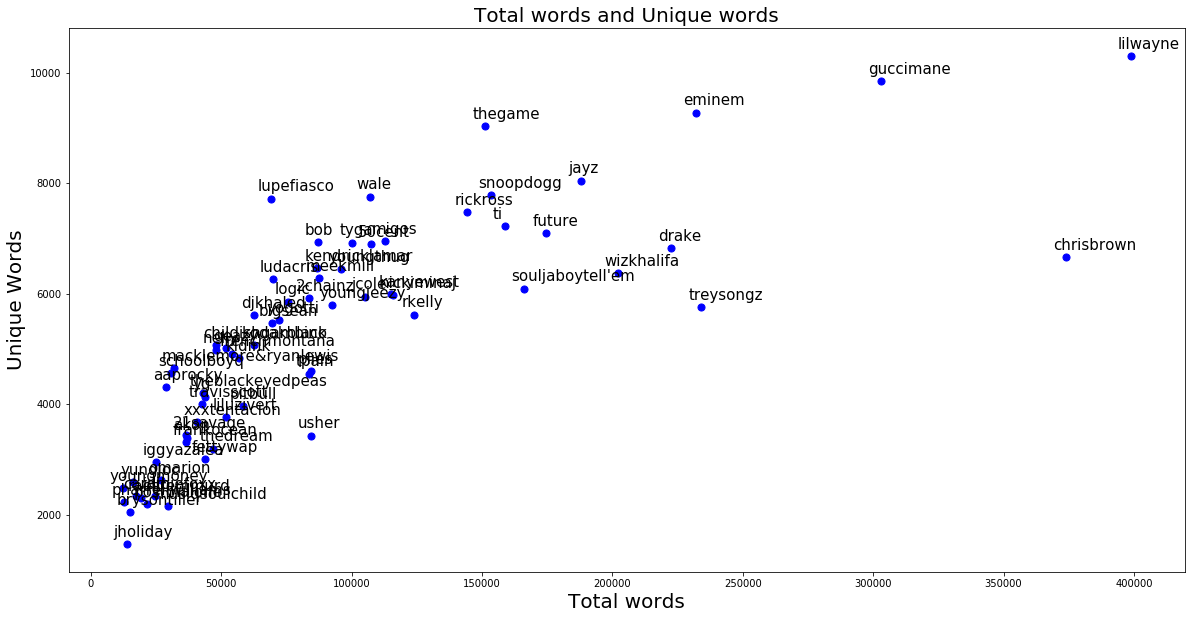

In [7]:
plt.figure(figsize = (20,10))
for i, name in enumerate(names):
    x = total[i]
    y = unique[i]
    plt.scatter(x, y, marker = '.', color = 'blue', s=200)
    plt.text(x-5000, y+130, name, fontsize = 15)
    
plt.title('Total words and Unique words', fontsize = 20)
plt.xlabel('Total words', fontsize = 20)
plt.ylabel('Unique Words', fontsize = 20)
plt.show()

As it is easier to achieve a high number of unique words from a longer carreer / more total words written, we can only compare artists with similar number of total words. We can say that Eminem has a wider vocabulary than Treysongz or Drake, because he used more words in similar number of songs, but it is hard to compare Eminem with Lupefiasco, who also seems to rise above his 'peers', as Eminem has written around 150.000 more words than him.

Let's visualize the Vocabulary Index for each artist calculated above: the ratio of Unique words written / Total words written

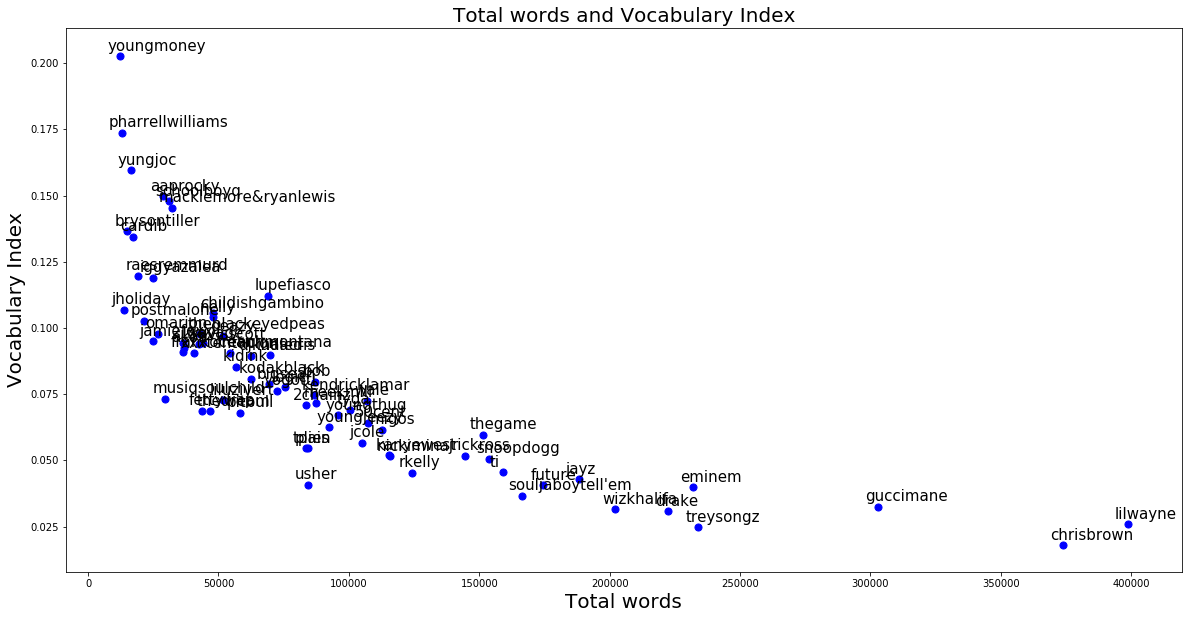

In [8]:
plt.figure(figsize = (20,10))
for i, name in enumerate(names):
    x = total[i]
    y = vocabi[i]
    plt.scatter(x, y, marker = '.', color = 'blue', s=200)
    plt.text(x-5000, y+0.002, name, fontsize = 15)
    
plt.title('Total words and Vocabulary Index', fontsize = 20)
plt.xlabel('Total words', fontsize = 20)
plt.ylabel('Vocabulary Index', fontsize = 20)
plt.show()

On this graph we can see that the more total words the artist uses, the lower his vocabulary score will be.
We should check this for number of songs as well.

In [9]:
''' The number of songs of each artist'''
songnos = df[['ARTIST', 'TITLE']].groupby('ARTIST').count()
songno = songnos[['TITLE']].values

In [10]:
songnos#.hist(bins = 50, figsize = (20,10))

,TITLE
ARTIST,
21savage,99
2chainz,209
50cent,326
aaprocky,95
akon,136
bigsean,161
bob,283
brysontiller,57
cardib,51


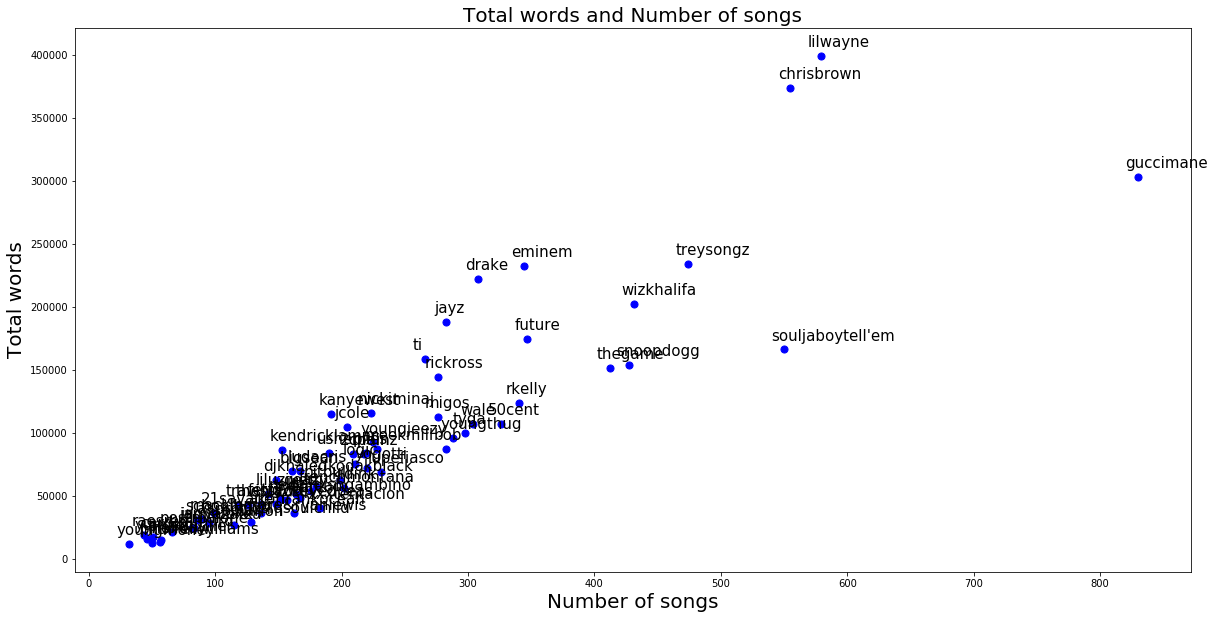

In [11]:
plt.figure(figsize = (20,10))
for i, name in enumerate(names):
    x = songno[i]
    y = total[i]
    plt.scatter(x, y, marker = '.', color = 'blue', s=200)
    plt.text(x-10, y+7000, name, fontsize = 15)
    
plt.title('Total words and Number of songs', fontsize = 20)
plt.xlabel('Number of songs', fontsize = 20)
plt.ylabel('Total words', fontsize = 20)
plt.show()

On this graph we can see that the total number of words and the number of songs are highly correlated. So normalization by simply dividing with the number of songs would not be feasible.

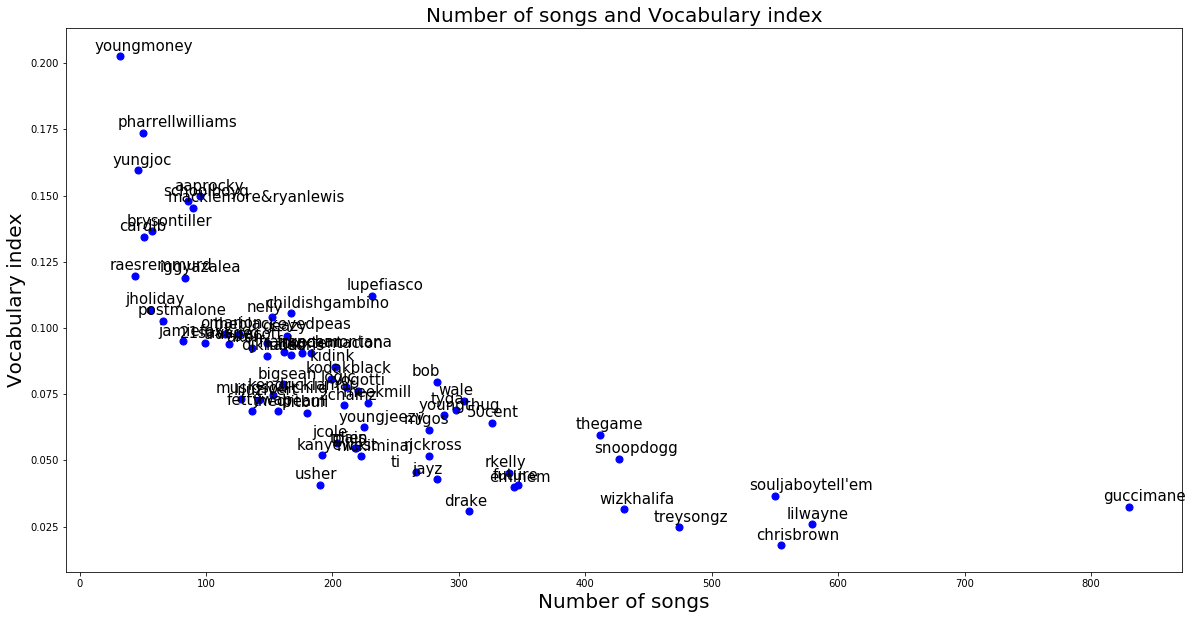

In [12]:
plt.figure(figsize = (20,10))
for i, name in enumerate(names):
    x = songno[i]
    y = vocabi[i]
    plt.scatter(x, y, marker = '.', color = 'blue', s=200)
    plt.text(x-20, y+0.002, name, fontsize = 15)
    
plt.title('Number of songs and Vocabulary index', fontsize = 20)
plt.xlabel('Number of songs', fontsize = 20)
plt.ylabel('Vocabulary index', fontsize = 20)
plt.show()

It is visible that the number of songs an artist has lower the vocabulary score significantly. We have to normalize the number of songs.

Let's see the number of songs on each album.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BB08C7CB38>]],
      dtype=object)

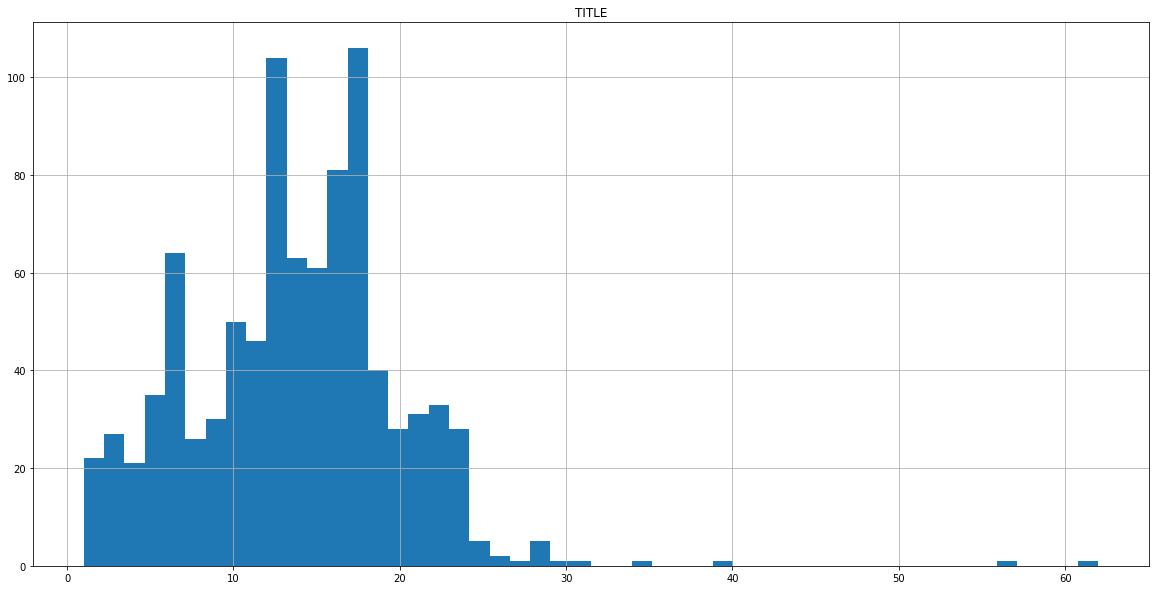

In [13]:
df[['ARTIST', 'ALBUM', 'TITLE']].groupby(['ARTIST', 'ALBUM']).count().hist(bins = 50, figsize = (20,10))

We can see that most albums have 10-20 songs. Let's try calculating the Vocabindex for each album, and then count the mean for each artist.

### Albums

In [14]:
group_albums = df.drop(columns = ['Unnamed: 0', 'YEAR', 'LYRICS', 'URL', 'ind', 'ARTISTSCORE']).groupby(['ARTIST', 'ALBUM']).sum().reset_index()
group_albums.head(5)

,ARTIST,ALBUM,100k,100s,10k,10s,10th,11s,11th,12play,...,zoning,zoo,zoogang,zoom,zoomin,zoop,zoovie,zoovier,zoowap,zulu
0,21savage,"""Issa Album""",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21savage,"""Savage Mode""",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21savage,"""Slaughter King""",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21savage,"""The Slaughter Tape""",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21savage,"""Without Warning""",0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [15]:
vocabscores = []
for i in range(group_albums.shape[0]):
    item = {}
    item['artist'] = group_albums.iloc[i,0]
    item['album'] = group_albums.iloc[i,1]
    item['unique_words'] = np.count_nonzero(group_albums.iloc[i,2:])
    item['total_words'] = group_albums.iloc[i,2:].sum()
    item['vocabindex'] = item['unique_words'] / item['total_words']
    vocabscores.append(item)
    
albumscores = pd.DataFrame(vocabscores)
albumscores.head(5)

,album,artist,total_words,unique_words,vocabindex
0,"""Issa Album""",21savage,5208,1224,0.235023
1,"""Savage Mode""",21savage,2516,693,0.275437
2,"""Slaughter King""",21savage,3614,920,0.254566
3,"""The Slaughter Tape""",21savage,3430,873,0.254519
4,"""Without Warning""",21savage,3491,990,0.283586


In [16]:
albumscores.groupby('artist').mean().sort_values('vocabindex', ascending = False)

,total_words,unique_words,vocabindex
artist,,,
lupefiasco,3317.500000,1385.357143,0.453983
childishgambino,2364.416667,948.583333,0.414812
aaprocky,3404.400000,1330.600000,0.408040
macklemore&ryanlewis,3907.666667,1490.000000,0.405135
jcole,3170.333333,1034.933333,0.396562
xxxtentacion,1087.066667,379.200000,0.392661
wale,3448.588235,1246.647059,0.389067
geazy,2750.200000,959.100000,0.384787
bob,2954.050000,1049.400000,0.374224


In [17]:
albumscores.groupby('artist').mean().index

Index(['21savage', '2chainz', '50cent', 'aaprocky', 'akon', 'bigsean', 'bob',
       'brysontiller', 'cardib', 'childishgambino', 'chrisbrown', 'djkhaled',
       'drake', 'eminem', 'fettywap', 'frankocean', 'frenchmontana', 'future',
       'geazy', 'guccimane', 'iggyazalea', 'jamiefoxx', 'jayz', 'jcole',
       'jholiday', 'kanyewest', 'kendricklamar', 'kidink', 'kodakblack',
       'liluzivert', 'lilwayne', 'logic', 'ludacris', 'lupefiasco',
       'macklemore&ryanlewis', 'meekmill', 'migos', 'musiqsoulchild', 'nelly',
       'nickiminaj', 'omarion', 'pharrellwilliams', 'pitbull', 'plies',
       'postmalone', 'raesremmurd', 'rickross', 'rkelly', 'schoolboyq',
       'snoopdogg', 'souljaboytell'em', 'theblackeyedpeas', 'thedream',
       'thegame', 'ti', 'tpain', 'travisscott', 'treysongz', 'tyga', 'usher',
       'wale', 'wizkhalifa', 'xxxtentacion', 'yg', 'yogotti', 'youngjeezy',
       'youngmoney', 'youngthug', 'yungjoc'],
      dtype='object', name='artist')

In [18]:
albummean_tw = albumscores.groupby('artist').mean()['total_words']
albummean_vindex = albumscores.groupby('artist').mean()['vocabindex']
albumnames = albumscores.groupby('artist').mean().index

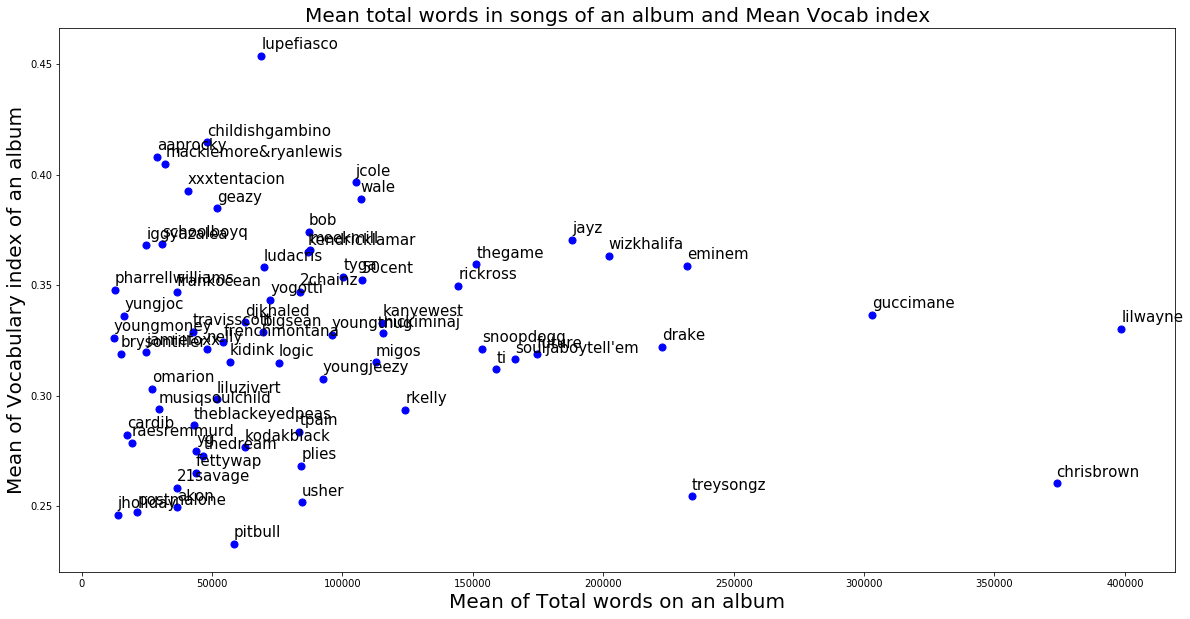

In [19]:
plt.figure(figsize = (20,10))
for i, name in enumerate(names):
    x = total[i]
    #x = albummean_tw[i]
    y = albummean_vindex[i]
    plt.scatter(x, y, marker = '.', color = 'blue', s=200)
    plt.text(x-20, y+0.003, name, fontsize = 15)
    
plt.title('Mean total words in songs of an album and Mean Vocab index', fontsize = 20)
plt.xlabel('Mean of Total words on an album', fontsize = 20)
plt.ylabel('Mean of Vocabulary index of an album', fontsize = 20)
plt.show()

This calculating method does't show a strong correlation between the number of total words used, and the Vocabulary index of artists. Artists with high number of songs are not that much unfavored, although still son't show high indexes. 

This method could be good enough, but the fact that Iggy Azaela is ranked before Eminem doesn't allow me to stop here.

## Random samples of each artists' songs

We will have a random sample of each artists songs, and calculate the Vocabulary index for those.

It will most likely still be unfavorable for artists who have 'dense' songs with lot of words, but in the event that happens we normalize for that as well.

This is how we will do the sampling:

In [20]:
df[df['ARTIST'] == 'eminem'].sample(n=50, random_state=11)

,Unnamed: 0,ALBUM,ARTIST,ARTISTSCORE,LYRICS,TITLE,URL,YEAR,ind,100k,...,zoning,zoo,zoogang,zoom,zoomin,zoop,zoovie,zoovier,zoowap,zulu
2731,2731,"""Encore""",eminem,327,Tell myself that I was doing alright\r\nThere'...,"""Crazy In Love""",https://www.azlyrics.com/lyrics/eminem/crazyin...,2004.0,2731,0,...,0,0,0,0,0,0,0,0,0,0
2854,2854,NaN,eminem,327,NaN,NaN,https://www.azlyrics.com/p://www.azlyrics.com/...,NaN,2854,0,...,0,0,0,0,0,0,0,0,0,0
2640,2640,"""Infinite""",eminem,327,"[Women Singing:]\r\nAin't no one special, spec...","""Searchin'""",https://www.azlyrics.com/lyrics/eminem/searchi...,1996.0,2640,0,...,0,0,0,0,0,0,0,0,0,0
2799,2799,"""Recovery""",eminem,327,Yeah! Oh! Get up! Where my dreads at?\r\nI sai...,"""W.T.P.""",https://www.azlyrics.com/lyrics/eminem/wtp.html,2010.0,2799,0,...,0,0,0,0,0,0,0,0,0,0
2707,2707,"""The Eminem Show""",eminem,327,[Ken Kaniff]\r\nIs this thing on?\r\nWhere'd e...,"""Curtains Close (Skit)""",https://www.azlyrics.com/lyrics/eminem/curtain...,2002.0,2707,0,...,0,0,0,0,0,0,0,0,0,0
2894,2894,NaN,eminem,327,[Verse 1:]\r\nYou probably gonna think that I'...,"""50 Ways""",https://www.azlyrics.com/lyrics/eminem/50ways....,NaN,2894,0,...,0,0,0,0,0,0,0,0,0,0
2881,2881,"""Kamikaze""",eminem,327,"[Joyner Lucas:]\r\nWhoa, Joyner, Joyner, yeah,...","""Lucky You""",https://www.azlyrics.com/lyrics/eminem/luckyyo...,2018.0,2881,0,...,0,0,0,0,0,0,0,0,0,0
2805,2805,"""Recovery""",eminem,327,"Yeah,\r\nYou know, technically, I'm not even r...","""Cinderella Man""",https://www.azlyrics.com/lyrics/eminem/cindere...,2010.0,2805,0,...,0,0,0,0,0,0,0,0,0,0
2965,2965,NaN,eminem,327,[Verse 1 - KXNG CROOKED:]\r\nMy name is KXNG C...,"""SHADY CXVPHER""",https://www.azlyrics.com/lyrics/eminem/shadycx...,NaN,2965,0,...,0,0,0,0,0,0,0,0,0,0
2689,2689,"""The Eminem Show""",eminem,327,"America, we love you\r\nHow many people are pr...","""White America""",https://www.azlyrics.com/lyrics/eminem/whiteam...,2002.0,2689,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
songnos.sort_values(by = 'TITLE', ascending = True).head(10)

,TITLE
ARTIST,
youngmoney,32
raesremmurd,44
yungjoc,46
pharrellwilliams,50
cardib,51
jholiday,56
brysontiller,57
postmalone,66
jamiefoxx,82


We will have to drop the artists who don't have 50 songs

In [3]:
df = df.drop(df[df['ARTIST'] == 'youngmoney'].index)
df = df.drop(df[df['ARTIST'] == 'raesremmurd'].index)
df = df.drop(df[df['ARTIST'] == 'yungjoc'].index)

In [48]:
del subdf

In [4]:
for artist in set(df['ARTIST'].values): #iterating over all the other artists
    artistdf = df[df['ARTIST'] == artist].sample(n=50, random_state=42)
    try:
        subdf = subdf.append(artistdf)
    except:
        subdf = artistdf

In [6]:
subdf.shape

(3300, 15873)

In [7]:
artist_50songs = subdf.drop(columns = ['Unnamed: 0', 'YEAR', 'LYRICS', 'URL', 'ind']).groupby('ARTIST').sum()

In [10]:
vocab_50_songs = vocab_score(artist_50songs)#.sort_values('unique_words', ascending = False)
vocab_50_songs

,name,total_words,unique_words,vocabindex
0,21savage,16949,2270,0.133931
1,2chainz,19962,2853,0.142922
2,50cent,17191,2886,0.167879
3,aaprocky,14174,3079,0.217229
4,akon,13077,1940,0.148352
5,bigsean,22440,2914,0.129857
6,bob,15791,2851,0.180546
7,brysontiller,13076,1856,0.141939
8,cardib,16383,2246,0.137093
9,childishgambino,15136,2750,0.181686


In [11]:
total50 = vocab_50_songs['total_words']
vocabi50 = vocab_50_songs['vocabindex']
names50 = vocab_50_songs['name']
unique50 = vocab_50_songs['unique_words']

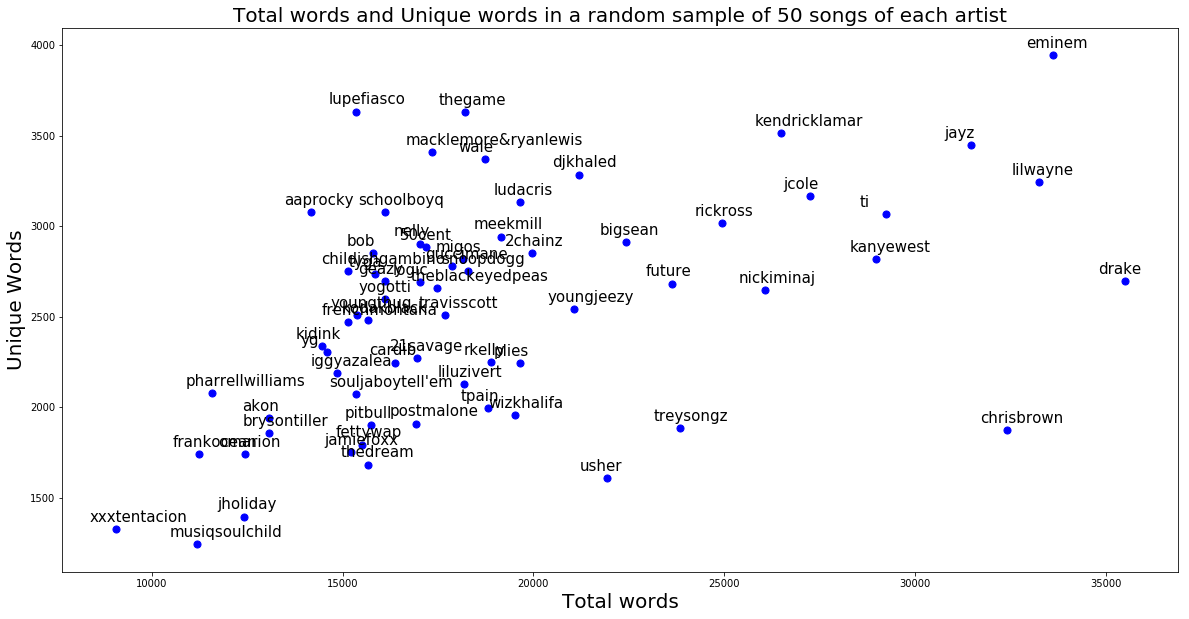

In [12]:
plt.figure(figsize = (20,10))
for i, name in enumerate(names50):
    x = total50[i]
    y = unique50[i]
    plt.scatter(x, y, marker = '.', color = 'blue', s=200)
    plt.text(x-700, y+40, name, fontsize = 15)
    
plt.title('Total words and Unique words in a random sample of 50 songs of each artist', fontsize = 20)
plt.xlabel('Total words', fontsize = 20)
plt.ylabel('Unique Words', fontsize = 20)
plt.show()

On this graph we can see two axes: artists to the right have more 'dense' lyrics, meaning that 50 of their songs contained more words than artists to the left. Artists that are closer to the top of the diagram than the bottom have wider vocabularies, meaning they used more unique words in 50 songs than the ones lower. Artists like Drake and Chris Brown can be considered repetitive, as they use a lot of words, but not much unique words. Artists like Schoolboy Q, Macklemore, Ludacris and Lupefiasco can be considered good lyricists, as they flaunt a lot of unique words without using that many words altogether. Eminem is in the top-right corner, meaning that a random sample of 50 Eminem songs contained a lot of total words, but a great number of unique words as well.

# 3. Comparing vocabulary with Billboard Success

In [13]:
bbscores = df[['ARTIST', 'ARTISTSCORE']].groupby('ARTIST').mean().values

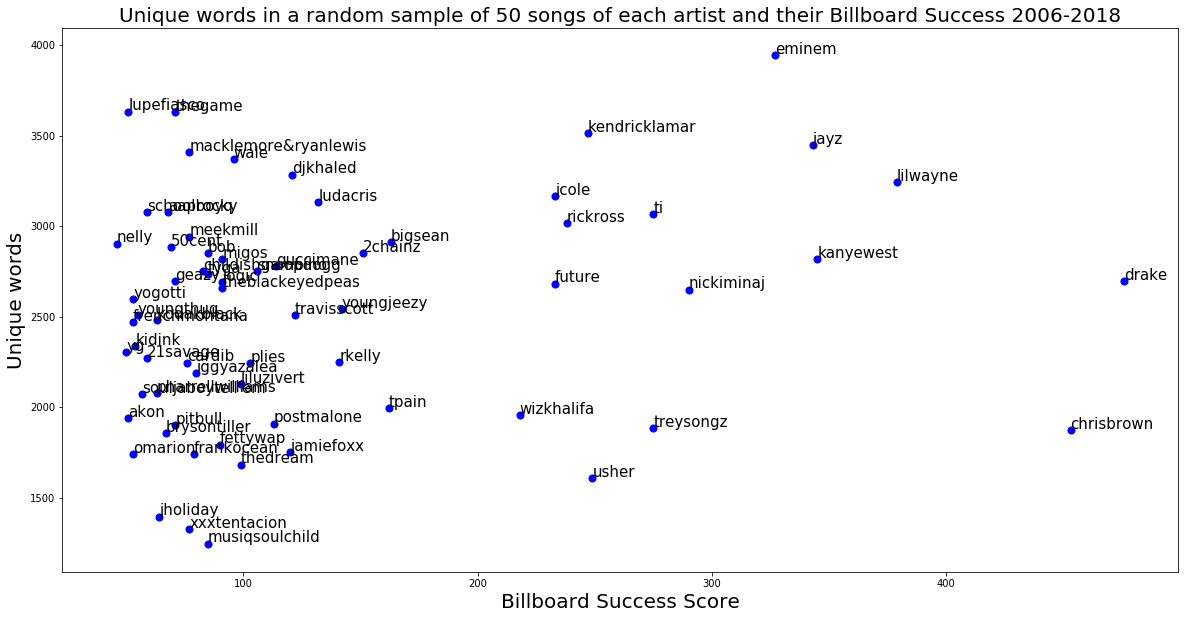

In [15]:
plt.figure(figsize = (20,10))
for i, name in enumerate(names50):
    y = unique50[i]
    x = bbscores[i]
    plt.scatter(x, y, marker = '.', color = 'blue', s=200)
    plt.text(x, y+7, name, fontsize = 15)
    
plt.title('Unique words in a random sample of 50 songs of each artist and their Billboard Success 2006-2018', fontsize = 20)
plt.xlabel('Billboard Success Score', fontsize = 20)
plt.ylabel('Unique words', fontsize = 20)
plt.show()

As we can see, the success on the Billboard list is not in strong connection with the vocabulary of the artist.

#### Pandas profiling

In [16]:
import pandas_profiling

C:\Users\User\Anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\User\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\User\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\User\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\User\Anac

In [21]:
vocab_50_songs['succes_score'] = bbscores
vocab_50_songs.head(5)

,name,total_words,unique_words,vocabindex,succes_score
0,21savage,16949,2270,0.133931,59
1,2chainz,19962,2853,0.142922,151
2,50cent,17191,2886,0.167879,69
3,aaprocky,14174,3079,0.217229,68
4,akon,13077,1940,0.148352,51


In [22]:
profile = pandas_profiling.ProfileReport(vocab_50_songs)
profile.to_file(outputfile="output.html")

# 4. Looking at the yearly changes

Let's pick a random sample of 50 songs from each year, and see the changes in lyricism. We will have to omit years 1993-1997.

In [57]:
df[['YEAR', 'TITLE']].groupby('YEAR').count().head(10)

,TITLE
YEAR,
1993.0,29
1994.0,14
1995.0,13
1996.0,42
1997.0,23
1998.0,86
1999.0,77
2000.0,167
2001.0,84


In [58]:
df2 = df.drop(df[df['YEAR'] == 1993.0].index)

In [59]:
df2 = df2.drop(df2[df2['YEAR'] == 1994.0].index)
df2 = df2.drop(df2[df2['YEAR'] == 1995.0].index)
df2 = df2.drop(df2[df2['YEAR'] == 1996.0].index)
df2 = df2.drop(df2[df2['YEAR'] == 1997.0].index)

In [60]:
for year in set(df2['YEAR'][df2['YEAR'].notna() == True].values): #iterating over all the years
    yeardf = df2[df2['YEAR'] == year].sample(n=50)
    try:
        yearsamples = yearsamples.append(yeardf)
    except:
        yearsamples = yeardf

In [61]:
yearsamples.shape

(1100, 15873)

In [62]:
yearsum = yearsamples.drop(columns = ['Unnamed: 0', 'ARTISTSCORE', 'LYRICS', 'URL', 'ind', 'ARTIST']).groupby('YEAR').sum()
yearsum.head(3)

,100k,100s,10k,10s,10th,11s,11th,12play,12th,13th,...,zoning,zoo,zoogang,zoom,zoomin,zoop,zoovie,zoovier,zoowap,zulu
YEAR,,,,,,,,,,,,,,,,,,,,,
1998.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
years_score = vocab_score(yearsum)
years_score

,name,total_words,unique_words,vocabindex
0,1998.0,12450,2978,0.239197
1,1999.0,14472,3180,0.219735
2,2000.0,13764,3147,0.228640
3,2001.0,13603,2980,0.219069
4,2002.0,12071,2832,0.234612
5,2003.0,14113,3014,0.213562
6,2004.0,12830,2824,0.220109
7,2005.0,12905,2899,0.224642
8,2006.0,14265,3315,0.232387
9,2007.0,12446,2721,0.218624


In [64]:
years = years_score['name']
years_vocab = years_score['vocabindex']
years_total = years_score['total_words']
years_unique = years_score['unique_words']

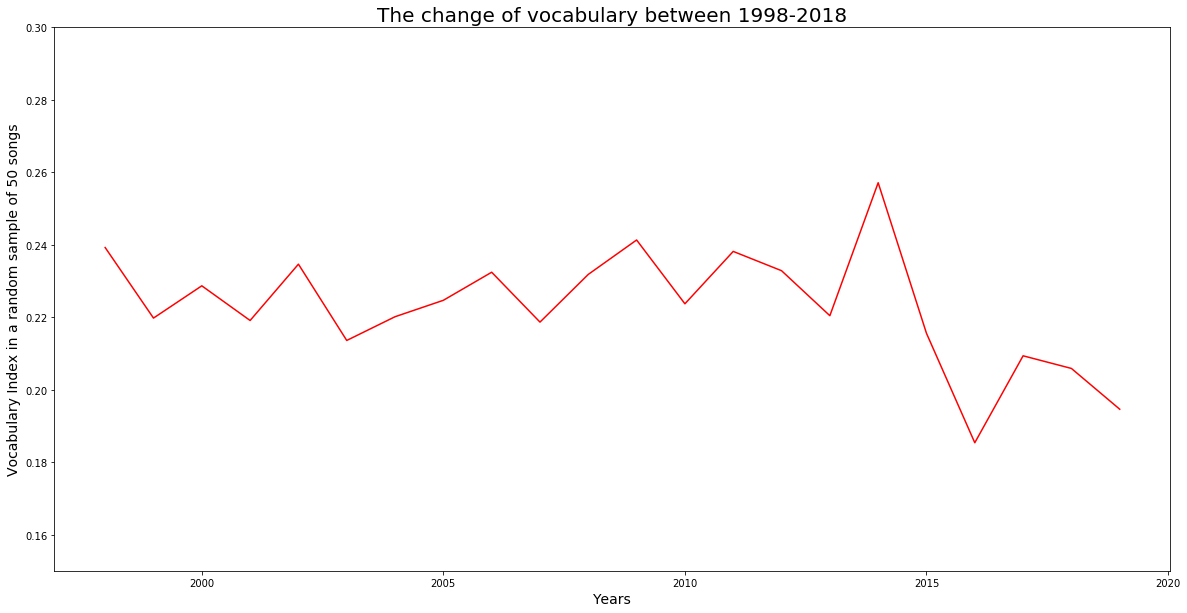

In [65]:
plt.figure(figsize = (20,10))
plt.ylim(0.15 , 0.30)
plt.plot(years, years_vocab, color = 'red')
plt.xlabel('Years', fontsize = 14)
plt.ylabel('Vocabulary Index in a random sample of 50 songs',  fontsize = 14)
plt.title('The change of vocabulary between 1998-2018',  fontsize = 20)
plt.show()

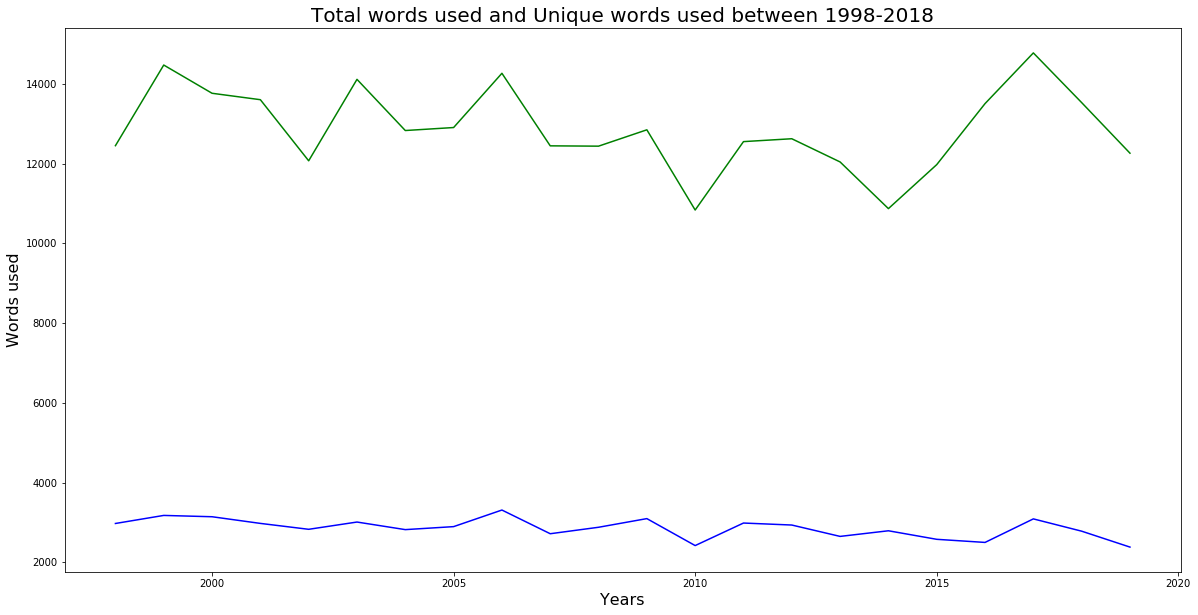

In [66]:
plt.figure(figsize = (20,10))
plt.plot(years, years_total, color='green')
plt.plot(years, years_unique, color='blue')
#plt.plot(years, years_vocab, color = 'red')
plt.xlabel('Years', fontsize = 16)
plt.ylabel('Words used', fontsize = 16)
plt.title('Total words used and Unique words used between 1998-2018', fontsize = 20)

plt.show()

## Checking if there are changes in the lyricism of the most successful artists

The top 10 most successful artists of 2006-2018

In [70]:
df[['ARTIST', 'ARTISTSCORE']].groupby('ARTIST').mean().sort_values(by= 'ARTISTSCORE', ascending=False).head(10)

,ARTISTSCORE
ARTIST,
drake,476
chrisbrown,453
lilwayne,379
kanyewest,345
jayz,343
eminem,327
nickiminaj,290
treysongz,275
ti,275


The songs of these artists

In [79]:
top10df = df[df['ARTIST'].isin(['drake','chrisbrown', 'lilwayne', 'kanyewest', 'jayz', 'eminem', 'nickiminaj', 'treysongz', 'ti', 'usher'])]
top10df = top10df.drop(columns = ['Unnamed: 0', 'ARTISTSCORE', 'ind'])
top10df.shape

(3512, 15870)

In [84]:
top10df_group = top10df.groupby(['ARTIST', 'YEAR']).sum().reset_index()
top10df_group

,ARTIST,YEAR,100k,100s,10k,10s,10th,11s,11th,12play,...,zoning,zoo,zoogang,zoom,zoomin,zoop,zoovie,zoovier,zoowap,zulu
0,chrisbrown,2005.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chrisbrown,2007.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chrisbrown,2009.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chrisbrown,2010.0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
4,chrisbrown,2011.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,chrisbrown,2012.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,chrisbrown,2013.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,chrisbrown,2014.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,chrisbrown,2015.0,1,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
9,chrisbrown,2016.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
top10artist = set(top10df_group['ARTIST'].values)
top10artist

{'chrisbrown',
 'drake',
 'eminem',
 'jayz',
 'kanyewest',
 'lilwayne',
 'nickiminaj',
 'ti',
 'treysongz',
 'usher'}

### Try it with only one artist

In [91]:
chrisbrown = top10df_group[top10df_group['ARTIST'] == 'chrisbrown']
chrisbrown

,ARTIST,YEAR,100k,100s,10k,10s,10th,11s,11th,12play,...,zoning,zoo,zoogang,zoom,zoomin,zoop,zoovie,zoovier,zoowap,zulu
0,chrisbrown,2005.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chrisbrown,2007.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chrisbrown,2009.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chrisbrown,2010.0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
4,chrisbrown,2011.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,chrisbrown,2012.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,chrisbrown,2013.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,chrisbrown,2014.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,chrisbrown,2015.0,1,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
9,chrisbrown,2016.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
vocabscores = []
for i in range(chrisbrown.shape[0]):
    item = {}
    item['artist'] = chrisbrown.iloc[i,0]
    item['year'] = chrisbrown.iloc[i,1]
    item['unique_words'] = np.count_nonzero(chrisbrown.iloc[i,2:])
    item['total_words'] = chrisbrown.iloc[i,2:].sum()
    item['vocabindex'] = item['unique_words'] / item['total_words']
    vocabscores.append(item)
pd.DataFrame(vocabscores)

,artist,total_words,unique_words,vocabindex,year
0,chrisbrown,4358,967,0.221891,2005.0
1,chrisbrown,10863,1704,0.156863,2007.0
2,chrisbrown,4387,945,0.215409,2009.0
3,chrisbrown,11314,2080,0.183843,2010.0
4,chrisbrown,8284,1677,0.202438,2011.0
5,chrisbrown,3695,826,0.223545,2012.0
6,chrisbrown,1088,438,0.402574,2013.0
7,chrisbrown,3287,880,0.267721,2014.0
8,chrisbrown,15420,2306,0.149546,2015.0
9,chrisbrown,11611,2130,0.183447,2016.0


### All the 10 artists

In [130]:
top10scores = {}

for artist in top10artist:
    subdf = top10df_group[top10df_group['ARTIST'] == artist]
    vocabscores = []
    for i in range(subdf.shape[0]):
        item = {}
        item['artist'] = subdf.iloc[i,0]
        item['year'] = subdf.iloc[i,1]
        item['unique_words'] = np.count_nonzero(subdf.iloc[i,2:])
        item['total_words'] = subdf.iloc[i,2:].sum()
        item['vocabindex'] = item['unique_words'] / item['total_words']
        vocabscores.append(item)
    top10scores[artist] = pd.DataFrame(vocabscores)

In [135]:
top10scores['eminem']

,artist,total_words,unique_words,vocabindex,year
0,eminem,3193,1252,0.392108,1996.0
1,eminem,2852,1094,0.383590,1998.0
2,eminem,5482,1779,0.324517,1999.0
3,eminem,7461,2008,0.269133,2000.0
4,eminem,7230,1874,0.259198,2002.0
5,eminem,3228,1107,0.342937,2003.0
6,eminem,7416,1930,0.260248,2004.0
7,eminem,2665,1121,0.420638,2005.0
8,eminem,2288,1088,0.475524,2006.0
9,eminem,9304,2566,0.275795,2009.0


In [147]:
import pylab  # for the legend plotting

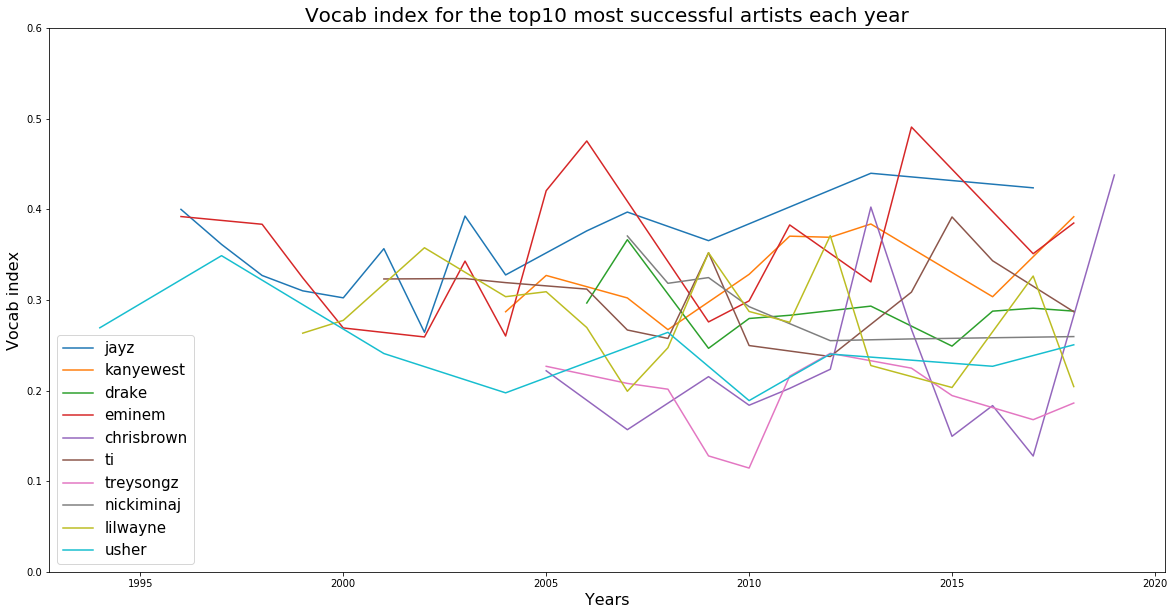

In [146]:
plt.figure(figsize = (20,10))
plt.ylim(0.0, 0.6)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

i = 0
for artist in top10scores:
    plt.plot(top10scores[artist]['year'], top10scores[artist]['vocabindex'], color=colors[i], label = artist)
    i += 1

plt.xlabel('Years', fontsize = 16)
plt.ylabel('Vocab index', fontsize = 16)
plt.title('Vocab index for the top10 most successful artists each year', fontsize = 20)
pylab.legend(loc='lower left', fontsize = 15)

plt.show()

Here we can see the changes year by year. The graph unfortunately misrepresents the years with very many songs and very few songs, as these conditions affect the Vocabulary index highly.
The earlier results still hold themselves, Eminem and Jay-Z scoring relatively high, and Usher and Treysongs lower.

# 5. Comparison with the GOATs

Now for a last comparison, let's compare the 'GOATs', the Greatests of All Time with the modern (2006-2018) successful artists. 

Note that there are 11 artists that are already represented in the Billboard artists.

(Eminem, Kendrick Lamar, Snoop Dogg, Jaz-Z, 50 Cent, Kanye West, J. Cole, Lil Wayne, Ludacris, T.I., A$AP Rocky)

In [ ]:
goatdf = pd.read_csv('GOAT_DTM_with_meta.csv', sep = ';')

In [149]:
goatdf.head(3)

,Unnamed: 0,ALBUM,ARTIST,ARTISTSCORE,LYRICS,TITLE,URL,YEAR,ind,100k,...,zipped,zipper,zombie,zombies,zone,zones,zonin,zoo,zoom,zulu
0,0,"""2Pacalypse Now""",2pac,NaN,[2Pac (Ice Cube):]\r\nHard like an erection\r\...,"""Young Black Male""",NaN,1991.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,"""2Pacalypse Now""",2pac,NaN,You know they got me trapped in this prison of...,"""Trapped""",NaN,1991.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,"""2Pacalypse Now""",2pac,NaN,"[2Pac (2Pac as ""Soulja""):]\r\nAll you wanted t...","""Soulja's Story""",NaN,1991.0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
goatdf = goatdf.drop(columns = ['Unnamed: 0', 'YEAR', 'LYRICS', 'URL', 'ind', 'ARTISTSCORE'])

In [152]:
group_goats = goatdf.groupby('ARTIST').sum()
group_goats.head(3)

,100k,10th,12th,14th,18th,1st,20s,21st,2nd,2pac,...,zipped,zipper,zombie,zombies,zone,zones,zonin,zoo,zoom,zulu
ARTIST,,,,,,,,,,,,,,,,,,,,,
2pac,0,0,0,0,0,0,0,0,0,129,...,2,0,0,0,22,1,0,2,0,1
50cent,0,1,0,0,1,2,2,0,1,3,...,1,6,0,0,12,1,2,2,0,0
Busta Rhymes,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,23,1,2,2,9,1


## The basic data of the GOATs

In [153]:
vocab_score(group_goats)

,name,total_words,unique_words,vocabindex
0,2pac,100856,6000,0.059491
1,50cent,83700,6146,0.073429
2,Busta Rhymes,73414,6536,0.089029
3,DMX,56038,4879,0.087066
4,Dr. Dre,25615,4101,0.160102
5,Eazy-E,16194,2507,0.154810
6,Ghostface Killah,71769,7272,0.101325
7,Ice Cube,49679,5524,0.111194
8,LL Cool J,57786,6326,0.109473
9,Method Man,69588,7172,0.103064


## Random sample of 50 songs for each artist

### Random sample of the Billboard artists

We will use this, but divide separate the artists that are featured in the GOATs as well.
We will have three groups:
- Only Billboard artist
- Only GOAT artist
- Both

In [157]:
artist_both = ['eminem', 'kendricklamar', 'jayz', 'snoopdogg', '50cent', 'kanyewest', 'jcole', 'lilwayne', 'ludacris', 'ti', 'aaprocky']

In [164]:
scored_samples_both = vocab_50_songs[vocab_50_songs['name'].isin(artist_both)]
scored_samples_both

,name,total_words,unique_words,vocabindex
2,50cent,17191,2886,0.167879
3,aaprocky,14174,3079,0.217229
13,eminem,33624,3947,0.117386
22,jayz,31480,3449,0.109562
23,jcole,27246,3168,0.116274
25,kanyewest,28984,2817,0.097192
26,kendricklamar,26502,3515,0.132631
30,lilwayne,33245,3244,0.097579
32,ludacris,19645,3135,0.159583
48,snoopdogg,18274,2750,0.150487


In [165]:
scored_samples_bb = vocab_50_songs[vocab_50_songs['name'].isin(artist_both) == False]
scored_samples_bb.head(5)

,name,total_words,unique_words,vocabindex
0,21savage,16949,2270,0.133931
1,2chainz,19962,2853,0.142922
4,akon,13077,1940,0.148352
5,bigsean,22440,2914,0.129857
6,bob,15791,2851,0.180546


### Random sample of the GOATs

In [173]:
set(goatdf['ARTIST'].values)

{'2pac',
 '50cent',
 'Busta Rhymes',
 'DMX',
 'Dr. Dre',
 'Eazy-E',
 'Ghostface Killah',
 'Ice Cube',
 'LL Cool J',
 'Method Man',
 'Mos Def',
 'Nas',
 'Notorius B.I.G.',
 'Outkast',
 'Rakim',
 'aaprocky',
 'eminem',
 'jayz',
 'jcole',
 'kanyewest',
 'kendricklamar',
 'lilwayne',
 'ludacris',
 'snoopdogg',
 'ti'}

Drop who are in both

In [175]:
justgoatdf = goatdf[goatdf['ARTIST'].isin(artist_both) == False]
set(justgoatdf['ARTIST'].values)

{'2pac',
 'Busta Rhymes',
 'DMX',
 'Dr. Dre',
 'Eazy-E',
 'Ghostface Killah',
 'Ice Cube',
 'LL Cool J',
 'Method Man',
 'Mos Def',
 'Nas',
 'Notorius B.I.G.',
 'Outkast',
 'Rakim'}

In [176]:
del goatsubdf

In [177]:
for artist in set(justgoatdf['ARTIST'].values): #iterating over all the other artists
    artistdf = justgoatdf[justgoatdf['ARTIST'] == artist].sample(n=50, random_state=42)
    try:
        goatsubdf = goatsubdf.append(artistdf)
    except:
        goatsubdf = artistdf

In [178]:
goatsubdf.shape

(700, 10707)

In [182]:
grouped_sample_goat = goatsubdf.groupby('ARTIST').sum()
grouped_sample_goat

,100k,10th,12th,14th,18th,1st,20s,21st,2nd,2pac,...,zipped,zipper,zombie,zombies,zone,zones,zonin,zoo,zoom,zulu
ARTIST,,,,,,,,,,,,,,,,,,,,,
2pac,0,0,0,0,0,0,0,0,0,19,...,0,0,0,0,7,0,0,1,0,0
Busta Rhymes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,1,0
DMX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Dr. Dre,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,2,0,0,1,0,0
Eazy-E,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,2,0,0,0,0,0
Ghostface Killah,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,3,0,0,3,0,0
Ice Cube,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,2,0,0,0,0,1
LL Cool J,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,4,0,0,0,0,0
Method Man,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,6,0,0,0,1,0


In [183]:
scored_samples_goat = vocab_score(grouped_sample_goat)
scored_samples_goat

,name,total_words,unique_words,vocabindex
0,2pac,18855,3157,0.167436
1,Busta Rhymes,14129,3005,0.212683
2,DMX,12931,2465,0.190627
3,Dr. Dre,13234,2946,0.222608
4,Eazy-E,13706,2413,0.176054
5,Ghostface Killah,12197,3528,0.289251
6,Ice Cube,12978,2882,0.222068
7,LL Cool J,13573,3132,0.230752
8,Method Man,12109,3322,0.274341
9,Mos Def,12662,2692,0.212605


## Visualisation

In [201]:
# Billboard
bb_names =  scored_samples_bb.reset_index()['name']
bb_total =  scored_samples_bb.reset_index()['total_words']
bb_unique = scored_samples_bb.reset_index()['unique_words']

# GOATs
goat_names = scored_samples_goat.reset_index()['name']
goat_total = scored_samples_goat.reset_index()['total_words']
goat_unique = scored_samples_goat.reset_index()['unique_words']

# Both
both_names =  scored_samples_both.reset_index()['name']
both_total =  scored_samples_both.reset_index()['total_words']
both_unique = scored_samples_both.reset_index()['unique_words']

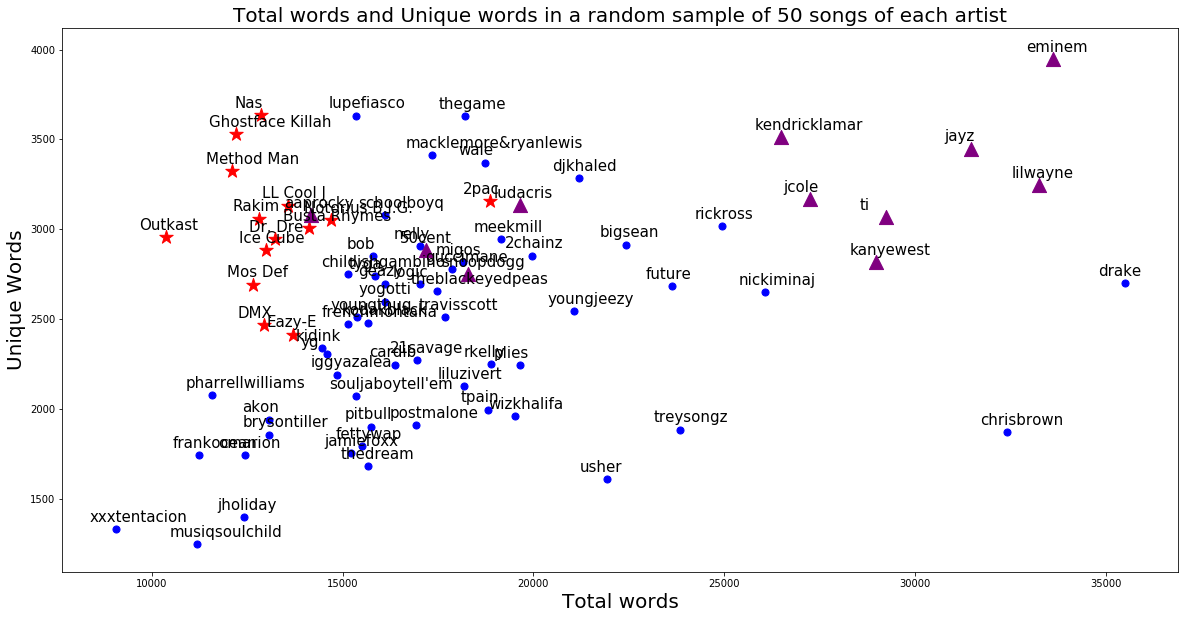

In [204]:
plt.figure(figsize = (20,10))

# Billboard
for i, name in enumerate(bb_names):
    x = bb_total[i]
    y = bb_unique[i]
    plt.scatter(x, y, marker = '.', color = 'blue', s=200)
    plt.text(x-700, y+40, name, fontsize = 15)
    
# GOATs
for i, name in enumerate(goat_names):
    x = goat_total[i]
    y = goat_unique[i]
    plt.scatter(x, y, marker = '*', color = 'red', s=200)
    plt.text(x-700, y+40, name, fontsize = 15)

# Both
for i, name in enumerate(both_names):
    x = both_total[i]
    y = both_unique[i]
    plt.scatter(x, y, marker = '^', color = 'purple', s=200)
    plt.text(x-700, y+40, name, fontsize = 15)
    
plt.title('Total words and Unique words in a random sample of 50 songs of each artist', fontsize = 20)
plt.xlabel('Total words', fontsize = 20)
plt.ylabel('Unique Words', fontsize = 20)
plt.show()

On this graph we can see, that the 'GOAT' aritsts tend to have a much wider vocabulary than the artists with similar number of total words used, and also thes are amongst the best in terms of Unique words used. 